# ADA project: Milestone 3 - Supporting notebook
### Team: YiYiSoDa - Yinghui Jiang, Yichen Wang, Sophia Ly, David Chaves

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
This notebook supports the datastory on: xxx
The goal of this project is to analyse the gender gap in movies. In order to do so the goal is to answer following questions: <br>
<li>How can the gender gap in the movie industry be grasped?
<li>Is there a difference of gender gap between genres?
<li>What is the gender gap across the world and how did it evolve over time?
<li>How will the gender gap evolve in the future and how long will it take for it to be closed?
<li>Is there a certain topic that correlates with one gender?
<li>Is there a correlation with off screen inequality and on screen inequality?

## <a id="ToC"></a> Table of contents

* [Functions](#Functions)
1. [Explore the dataset](#1.-Explore-the-dataset)
    1. [movie.metadata.tsv.gz](#1.1-movie.metadata.tsv.gz)
    2. [character.metadata.tsv.gz](#1.2-character.metadata.tsv.gz)
    3. [plot_summaries.txt](#1.3-plot_summaries.txt)
    4. [tvtropes.clusters.txt](#1.4-tvtropes.clusters.txt)
    5. [title.crew.tsv.gz](#1.5-title.crew.tsv.gz)
    
* [Bechdel test](#Bechdel-test)
* [Sentiment Analysis](#Sentiment-analysis)
2. [Quantification of gender inequality](#2.-Quantification-of-gender-inequality)
    1. [Female ratio](#2.1-Female-ratio)
        1. [Female ratio in cast](#2.1.1-Female-ratio-in-cast)
        2. [Female ratio in directors](#2.1.2-Female-ratio-in-directors)
        3. [Female ratio in writers](#2.1.3-Female-ratio-in-writers)
    2. [Age gap between males and females in cast](#2.2-Age-gap-between-males-and-females-in-cast)
    3. [Cast distribution in different domains](#2.3-Cast-distribution-in-different-domains)
        1. [Genre](#2.3.1-Genre)
        2. [Countries](#2.3.2-Countries)
    4. [Change over time](#2.4-Change-over-time)
3. [Sentiment Analysis](#3.-Sentiment-Analysis)
    1. [Extract verbs and adjectives of the plot's summaries](#3.1-Extract-verbs-and-adjectives-of-the-plot's-summaries)
    2. [Sentiment Analysis and Word Frequency](#3.2-Sentiment-Analysis-and-Word-Frequency)
    3. [Extract sentences for both genders](#3.3-Extract-sentences-for-both-genders)
    4. [Sentiment Analysis on sentences](#3.4-Sentiment-Analysis-on-sentences)
    5. [Topic modelling on sentences](#3.5-Topic-modelling-on-sentences)

<AxesSubplot:xlabel='flipper_length_mm', ylabel='Count'>

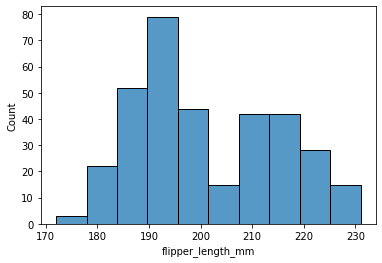

In [1]:
import seaborn as sns
penguins = sns.load_dataset("penguins")
sns.histplot(data=penguins, x="flipper_length_mm")

In [351]:
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
import tarfile
import re
import gzip
import spacy
import warnings
import math
import json
import bokeh
import gensim
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
from bokeh.resources import INLINE
import bokeh.io
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, Slider, HoverTool, Select, Span, Tabs, Panel, Label
from bokeh.palettes import brewer
from bokeh.models.widgets.sliders import RangeSlider
from bokeh.layouts import layout
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
from PIL import Image
warnings.filterwarnings('ignore')

data_folder = './data/MovieSummaries/'
corenlp_folder = './data/corenlp_plot_summaries/'

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [4]:
import ipywidgets as widgets

## Functions

In [5]:
def NaN_percentage(df):
    '''
    Calculates number of NaN
    
    Returns: a df with columnname and their respective number of NaN and what percentage this corresponds to.
    Args:
        df = movies, characters
    '''
    
    n_NaN = []
    perc_NaN = []
    length = len(df)

    for column in df:
        i_nan = df[column].isna().sum()
        perc_nan = i_nan/ length
        n_NaN.append(i_nan)
        perc_NaN.append(perc_nan)

    # Create df with results
    index_df = df.columns.to_list()
    df_NaN = pd.DataFrame({'number of NaN':n_NaN, 'percentage of NaN':perc_NaN}, index= index_df )
    return df_NaN

In [6]:
def get_gender(name: str,neutral_gender_names):
    """
    Gets the gender of a person from his person name match to the files male.txt and female.txt
    
    :param name: name of the person
    :return: genre, 'M' for male, 'F' for female and None else
    """
    # names that are neutral genders
    for n in name.split(): # we check each word in the name
        if n in neutral_gender_names: # No gender for names that are of both genders
            return None
        elif n in males:
            return 'M'
        elif n in females:
            return 'F'

    return None

In [7]:
def get_gender_ratio(s, gender):
    ''' 
    Calculates the ratio gender
    Arg:
        s: Object containing all male or female actor in a genre. (M or F)
        gender: the gender for which the ratio should be computed for
    ''' 
    gender_count = 0
    if(type(s) == str):
        for i in range(len(s)):
            if s[i] == gender:
                gender_count = gender_count+1
            
    else:
        gender_count = len(s[s['actor_gender']==gender])
    
    return round(gender_count/len(s), 4)

In [8]:
def genderratio_domain(df, domain, threshold,characters, gender):
    ''' 
    
    Arg:
        df = movie_genres
        domain = domain
        threshold = number of movies has to be higher than threshhold for domain specific value to be counted as general
        characters = characters df
        gender = 'F' or 'M'
    '''
    if gender == 'F':
        gender_ratio = "female_ratio"
    else:
        gender_ratio = "male_ratio"  
    
    # generate dataframe containing the actors gender and domain-specific value of the movie
    domain_ct = df[domain].value_counts()

    # consider a domain is general when at least threshold-number of movies in it
    general_genres = domain_ct[domain_ct > threshold]
    general_genres = general_genres.index.tolist()
    character_domain = pd.merge(left = characters, right = df, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
    
    # merge losses some data, it's possible that in some years no character is matching
    if len(character_domain)>0:
        # Extract genres that has actor/ actress
        # Sum the number of male / female actor per genre and calculate female ratio
        gender_genres = character_domain[character_domain[domain].isin(general_genres)][['actor_gender', domain]].groupby(domain).agg('sum')
        gender_genres = gender_genres.reset_index(level=0)
        # checking for general genre can lead to loss of some data
        if len(gender_genres)>0:
            gender_genres[gender_ratio] = gender_genres['actor_gender'].apply(lambda x: get_gender_ratio(x,gender))
            gender_genres = gender_genres.drop(columns=['actor_gender'])
            gender_genres = gender_genres.sort_values(by=gender_ratio, ascending=False)
    else:
        gender_genres = []
    
    return gender_genres

In [9]:
def crossvalidate_degree(X, y, random_state):
    # Find polynomial regression degree
    maxdegree= 10 # The maximum degree we would like to test
    rmses = []
    model =  LinearRegression()
    degree = []
    min_rmse, min_deg = 1e10, 0
    seed = np.random.seed(random_state)
    # Split data in training, test data
    x_train, x_test, y_train, y_test = train_test_split(X, y, random_state = seed, train_size= 0.7)
    degrees = np.arange(1,maxdegree+1,1)

    for deg in range(1,maxdegree+1):

        # Do polynomial transform
        poly_features = PolynomialFeatures(degree=deg, include_bias=False)
        x_poly_train = poly_features.fit_transform(x_train)

        # Linear regression
        poly_reg = LinearRegression()
        poly_reg.fit(x_poly_train, y_train)

        # Compare with test data
        x_poly_test = poly_features.fit_transform(x_test)
        poly_predict = poly_reg.predict(x_poly_test)
        poly_mse = mean_squared_error(y_test, poly_predict)
        poly_rmse = np.sqrt(poly_mse)
        degree.append(deg)
        rmses.append(poly_rmse)

        # Cross-validation of degree
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = deg

    # Plot and present results
    print('Best degree {} with RMSE {}'.format(min_deg, min_rmse))
    return min_deg

In [10]:
def sort_to_genre(df, movie_genres):
# df = top_male_genres_tot    
    sort_genres = movie_genres.groupby('genres').count().sort_values('wiki_movie_id', ascending= False)
    sorter = sort_genres.reset_index().genres.values
    df_sort = df.copy()
    df_sort.genres = df_sort.genres.astype('category')
    df_sort.genres = df_sort.genres.cat.set_categories(sorter)
    sorted_df = df_sort.sort_values(["genres"])
    return sorted_df

## Explore the dataset
[Back to table of contents](#ToC)

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Each dataset is first loaded into memory, then the number of NaN values were calculated. There are multiple ways on how to handle NaN such as discarding row, replacing with mean/ median. Since the best way of handling NaN values depend on which question should be answered, isn't treated yet.
Wherever tuples contain multiple values, rows were added to the dataframe and the values split into those rows. With this each row only contains one value.

### 1.1 movie.metadata.tsv.gz


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


##### Loading data

In [11]:
movies = data_folder + 'movie.metadata.tsv'
movies_cols = ['wiki_movie_id', 'freebase_movie_id', 'movie_name','release_date','box_office_revenue',
              'movie_runtime', 'languages', 'countries','genres']

movies = pd.read_csv(movies, sep='\t', names=movies_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
movies.head(2)

,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,movie_runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."


In [12]:
movies_NaN = NaN_percentage(movies)
movies_NaN

,number of NaN,percentage of NaN
wiki_movie_id,0,0.000000
freebase_movie_id,0,0.000000
movie_name,0,0.000000
release_date,6903,0.084450
box_office_revenue,73340,0.897224
movie_runtime,20450,0.250180
languages,0,0.000000
countries,0,0.000000
genres,0,0.000000


##### Adding rows to dataframe where language-tuple has multiple values 

In [13]:
# relational table between movies with lauguages, countries and genres.
# keep wiki_movie_id, lauguages, countries, genres

movie_languages = movies.copy()
movie_languages['languages'] = movie_languages['languages'].apply(lambda x: list(eval(x).values()))
movie_languages = movie_languages.explode('languages', ignore_index = True)
movie_languages = movie_languages.drop(columns=['freebase_movie_id', 'movie_name','box_office_revenue',
              'movie_runtime', 'countries','genres'])
movie_languages.languages.value_counts()

English Language                        40891
Hindi Language                           3744
Spanish Language                         3673
French Language                          3422
Silent film                              3183
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Tok Pisin Language                          1
Pawnee Language                             1
Kuna language                               1
Name: languages, Length: 207, dtype: int64

##### Adding rows to dataframe where countries-tuple has multiple values 

In [14]:
movie_countries = movies.copy()
movie_countries['countries'] = movie_countries['countries'].apply(lambda x: list(eval(x).values()))
movie_countries = movie_countries.explode('countries', ignore_index = True)
movie_countries = movie_countries.drop(columns=['freebase_movie_id', 'movie_name','box_office_revenue',
              'movie_runtime', 'languages','genres'])
movie_countries.countries.value_counts()

United States of America    34408
India                        8411
United Kingdom               7868
France                       4395
Italy                        3163
                            ...  
Republic of China               1
Macau                           1
Palestinian Territories         1
German Language                 1
Ukranian SSR                    1
Name: countries, Length: 147, dtype: int64

##### Adding rows to dataframe where language-tuple had multiple values 

In [15]:
movie_genres = movies.copy()
movie_genres['genres'] = movie_genres['genres'].apply(lambda x: list(eval(x).values()))
movie_genres = movie_genres.explode('genres', ignore_index = True)
movie_genres = movie_genres.drop(columns=['freebase_movie_id', 'movie_name','box_office_revenue',
              'movie_runtime', 'languages','countries'])
movie_genres.genres.value_counts()

Drama                   34007
Comedy                  16349
Romance Film            10234
Black-and-white          9094
Action                   8798
                        ...  
Romantic thriller           1
Comdedy                     1
C-Movie                     1
Silhouette animation        1
Homoeroticism               1
Name: genres, Length: 363, dtype: int64

### 1.2 character.metadata.tsv.gz

Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


In [16]:
characters = data_folder + 'character.metadata.tsv'
char_cols = ['wiki_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'actor_date_of_birth', 
             'actor_gender', 'height', 'actor_ethnicity', 'actor_name', 'actor_age_at_release', 'freebase_map_id', 'freebase_character_id', 'freebase_actor_id']
characters = pd.read_csv(characters, sep='\t', names=char_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))
characters.head()

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_date_of_birth,actor_gender,height,actor_ethnicity,actor_name,actor_age_at_release,freebase_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [17]:
characters_NaN = NaN_percentage(characters)
characters_NaN

,number of NaN,percentage of NaN
wiki_movie_id,0,0.000000
freebase_movie_id,0,0.000000
release_date,10010,0.022211
character_name,257875,0.572205
actor_date_of_birth,106145,0.235528
actor_gender,45609,0.101203
height,295845,0.656457
actor_ethnicity,344611,0.764665
actor_name,1228,0.002725
actor_age_at_release,158113,0.350841


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
An analysis is done to see where gender information is missing and where impossible age under 0 exist. Since the whole tasks  is based on gender, the characters without gender information were dropped. The characters with age under 0 first remain, since not all task need this feature. 

In [18]:
print('number of movies:\t{}\nnumber of characters:\t{}\nwith gender info:\t{}\nnegative age:\t\t{}'.format(characters.wiki_movie_id.unique().size, len(characters),characters.actor_gender.notnull().sum(), len(characters.query('actor_age_at_release <= 0'))))
characters.actor_gender.value_counts()

number of movies:	64330
number of characters:	450669
with gender info:	405060
negative age:		433


M    270257
F    134803
Name: actor_gender, dtype: int64

In [19]:
# drop characters has no gender info
characters = characters.loc[characters.actor_gender.notnull()]

### 1.3 plot_summaries.txt

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [20]:
plots =  pd.read_csv(data_folder + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_movie_id','plot'))
plots.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [21]:
plots_NaN = NaN_percentage(plots)
plots_NaN

,number of NaN,percentage of NaN
wiki_movie_id,0,0.0
plot,0,0.0


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The plot summary df is merged with the movie df. This movies_with_plots df can later be analysed regarding gender.    

In [22]:
movies_with_plots = pd.merge(left = movies, right = plots, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
print('number of movies:\t{}\nnumber of plots:\t{}\ncombined info:\t\t{}'.format(characters.wiki_movie_id.unique().size, len(plots), len(movies_with_plots)))
movies_with_plots.head(3)

number of movies:	63652
number of plots:	42303
combined info:		42204


,wiki_movie_id,freebase_movie_id,movie_name,release_date,box_office_revenue,movie_runtime,languages,countries,genres,plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."


### 1.4 tvtropes.clusters.txt

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv. 

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The tvtropes dataset was used for sentiment analysis. After reading the trope description on https://tvtropes.org/ each trope was manually given a rating based on how well a character was shown, where -1 is bad, 0 is neutral and 1 is positive. Some tropes where easy to assess, for example when judging adjectives were used in the description such as 'dumb'. For some tropes no rating could be given such as 'granola person'. The rating was not based on whether a character is evil or good but on how strong/ intelligent/ complex a character is. E.g., an evil person can be intelligent. <br>

In [23]:
tvtropes = pd.read_csv('./data/tvtropes.clusters_assessement.txt', sep = '\t', header=None, names=('char_type', 'details', 'sentiment'))

# split the details to seprate columns
details = tvtropes['details'].str.slice(start=1, stop=-1).str.split('", "|": "', expand=True)

tvtropes['char_name'] = details[1]
tvtropes['movie_name'] = details[3]
tvtropes['freebase_map_id'] = details[5]
tvtropes['actor_name'] = details[7].str.replace('"' ,'',regex=True)
tvtropes.drop(columns=['details'], inplace = True)

tvtropes.head(3)

,char_type,sentiment,char_name,movie_name,freebase_map_id,actor_name
0,absent_minded_professor,-1,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,-1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,-1,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen


In [24]:
tropes_NaN = NaN_percentage(tvtropes)
plots_NaN

,number of NaN,percentage of NaN
wiki_movie_id,0,0.0
plot,0,0.0


### 1.5 title.crew.tsv.gz

Contains the director and writer information for all the titles in IMDb.

1. tconst (string) - alphanumeric unique identifier of the title
2. Directors (array of nconsts) - director(s) of the given title
3. Writers (array of nconsts) – writer(s) of the given title

In [25]:
crew = pd.read_csv('data/title.crew.tsv.gz', compression='gzip', sep='\t', na_values="\\N")
crew.head(3)

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    
To link the titles of the movies and the writers/directors we need two additional datasets:
1. title.akas.tsv.gz, that contains titles and tconst
2. data/name.basics.tsv.gz, that contains writers/directors id and their names

In [26]:
# Create dataset and save as pickle
'''
titles = pd.read_csv('data/title.akas.tsv.gz', compression='gzip', sep='\t', na_values="\\N", usecols=['titleId', 'title'], low_memory=True)
titles = titles.rename(columns={'titleId' : 'tconst'})
titles.head(3)

## Inner join titles and metadata to only keep the movies that are in the original set
titles = pd.merge(titles, movies.rename(columns={'movie_name' : 'title'}).title, on='title', how='inner')
titles.head(3)

## Inner join crew and titles on tconst to have the title name with the directors and writers
crew = pd.merge(crew, titles, on='tconst', how='inner')
crew.drop('tconst', axis=1, inplace=True) ## Drop useless column "tconst"
crew = crew.drop_duplicates() ## Drop duplicates i.e. titles that have multiple "tconst" values
del titles ## Free memory
crew.head(3)

# Create two data frame for directors and writers, and drop the row without directors and writers.
directors = crew[['directors', 'title']].dropna()
writers = crew[['title', 'writers']].dropna()

# Directors and writers are list, so we transform them into rows
directors['directors'] = directors['directors'].str.split(pat=',')
writers['writers'] = writers['writers'].str.split(pat=',')
directors = directors.explode('directors')
writers = writers.explode('writers')

names = pd.read_csv('data/name.basics.tsv.gz', compression='gzip', sep='\t', na_values="\\N", usecols=['nconst', 'primaryName'], low_memory=True)
names.head(3)

directors = pd.merge(directors, names.rename(columns={'nconst' : 'directors'})[['directors', 'primaryName']],
                     on='directors', how='inner')
directors.drop('directors', axis=1, inplace=True)
directors.rename(columns={'primaryName' : 'director_name'}, inplace=True)
directors = directors.drop_duplicates()
directors.head(3)

writers = pd.merge(writers, names.rename(columns={'nconst' : 'writers'})[['writers', 'primaryName']],
                   on='writers', how='inner')
writers.drop('writers', axis=1, inplace=True)
writers.rename(columns={'primaryName' : 'writer_name'}, inplace=True)
writers = writers.drop_duplicates()
del names ## Free memory
writers.head(3)

# We use 2 dataset, male.txt and female.txt, to match the directors and writers names to a gender.

males = set(pd.read_csv('data/male.txt', names=['names'], skiprows=5).names.tolist())
females = set(pd.read_csv('data/female.txt', names=['names'], skiprows=5).names.tolist())
neutral_gender_names = males.intersection(females)

print(f"Numbers of names that are of neutral genders: {len(neutral_gender_names)}")

# Write to pickle
directors['gender'] = directors.director_name.apply(get_gender,neutral_gender_names)
writers['gender'] = writers.writer_name.apply(get_gender,neutral_gender_names)

print(f"Null gender values: {directors.gender.isnull().sum() / len(directors):.2%}")
print(f"Null gender values: {writers.gender.isnull().sum() / len(writers):.2%}")

directors = directors.dropna()
writers = writers.dropna()

writers.to_pickle("data/writers.pickle")
directors.to_pickle("data/directors.pickle")

# We lose 30-35 % of the data.'''

'\ntitles = pd.read_csv(\'data/title.akas.tsv.gz\', compression=\'gzip\', sep=\'\t\', na_values="\\N", usecols=[\'titleId\', \'title\'], low_memory=True)\ntitles = titles.rename(columns={\'titleId\' : \'tconst\'})\ntitles.head(3)\n\n## Inner join titles and metadata to only keep the movies that are in the original set\ntitles = pd.merge(titles, movies.rename(columns={\'movie_name\' : \'title\'}).title, on=\'title\', how=\'inner\')\ntitles.head(3)\n\n## Inner join crew and titles on tconst to have the title name with the directors and writers\ncrew = pd.merge(crew, titles, on=\'tconst\', how=\'inner\')\ncrew.drop(\'tconst\', axis=1, inplace=True) ## Drop useless column "tconst"\ncrew = crew.drop_duplicates() ## Drop duplicates i.e. titles that have multiple "tconst" values\ndel titles ## Free memory\ncrew.head(3)\n\n# Create two data frame for directors and writers, and drop the row without directors and writers.\ndirectors = crew[[\'directors\', \'title\']].dropna()\nwriters = crew[[\'

In [27]:
directors = pd.read_pickle("data/directors.pickle")
writers = pd.read_pickle("data/writers.pickle")

In [28]:
directors.title.value_counts()

Home                            354
Independent Lens                312
Alone                           285
Scene of the Crime              273
Trapped                         213
                               ... 
A Little Thing Called Murder      1
Marci X                           1
The Shrink Is In                  1
The Pentagon Wars                 1
The Twist                         1
Name: title, Length: 47253, dtype: int64

In [29]:
writers.sample(3)

,title,writer_name,gender
263104,Cut,Dave Warner,M
170280,Topless,Bruce Helford,M
78593,Our Daily Bread,Hans Joachim Beyer,M


In [30]:
writers.gender.value_counts()

M    279186
F     73026
Name: gender, dtype: int64

### Bechdel test

https://bechdeltest.com/
The Bechdel Test is a simple and popular measure of feminism in works of fiction. The rules of
the test were first defined back in 1985 in a comic strip featuring two queer women who could
not find a movie that:
1) Has at least two women in it,
2) who talk to each other,
3) about something other than a man

Columns in this dataset: 
1. title: moive title, 
2. year: year of release, 
4. bt_score: the actual Bechdel score, 
5. dubious: whether the submitter considered the rating is dubious or not.
6. Imdb ID, 
7. id: unique website ID, 
8. submitterid: ID of the submitter, 
9. date: the date of entry into the dataset,
10. visible: if the movied is approveed

In [31]:
bechdel = pd.read_csv('./data/Bechdel_detailed.csv', index_col=0)
bechdel.rename(columns={'rating': 'bt_score'}, inplace=True)
bechdel.head(2)

,title,year,bt_score,dubious,imdbid,id,submitterid,date,visible
0,Passage de Venus,1874.0,0.0,0.0,3155794.0,9602.0,18880.0,2021-04-02 20:58:09,1.0
1,La Rosace Magique,1877.0,0.0,0.0,14495706.0,9804.0,19145.0,2021-05-11 00:11:22,1.0


In [32]:
bechdel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9373 entries, 0 to 9372
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        9373 non-null   object 
 1   year         9373 non-null   float64
 2   bt_score     9373 non-null   float64
 3   dubious      9074 non-null   float64
 4   imdbid       9373 non-null   float64
 5   id           9373 non-null   float64
 6   submitterid  9373 non-null   float64
 7   date         9373 non-null   object 
 8   visible      9373 non-null   float64
dtypes: float64(7), object(2)
memory usage: 732.3+ KB


Drop NaN and duplicated datapoints

In [33]:
bechdel = bechdel.dropna().reset_index(drop=True)
len(bechdel)

9074

In [34]:
bechdel[bechdel.duplicated()]

,title,year,bt_score,dubious,imdbid,id,submitterid,date,visible
839,Saboteur,1956.0,1.0,0.0,35279.0,5938.0,11248.0,2014-11-22 17:38:29,1.0
1924,Terms of Endearment,1983.0,1.0,1.0,86425.0,4448.0,7970.0,2013-08-07 09:53:44,1.0
3149,Ayneh,1997.0,3.0,0.0,117056.0,4380.0,7796.0,2013-07-21 16:53:37,1.0
6183,Last Call at the Oasis,2011.0,3.0,0.0,2043900.0,4889.0,8867.0,2013-11-29 21:16:54,1.0
6826,Puella Magi Madoka Magica the Movie Part III: ...,2013.0,3.0,0.0,2457282.0,4980.0,9023.0,2013-12-24 20:34:24,1.0
8075,Moana,2016.0,3.0,0.0,3521164.0,7292.0,14251.0,2016-11-24 02:28:18,1.0
8834,Descendants 3,2019.0,3.0,0.0,8022928.0,8816.0,17295.0,2019-08-12 18:52:11,1.0
9063,"Suicide Squad, The",2021.0,3.0,0.0,6334354.0,10004.0,19435.0,2021-08-08 22:16:55,1.0
9070,Cruella,2021.0,3.0,0.0,3228774.0,9861.0,19231.0,2021-06-01 03:16:58,1.0


In [35]:
bechdel.drop_duplicates(inplace=True)
bechdel = bechdel.reset_index(drop=True)
bechdel

,title,year,bt_score,dubious,imdbid,id,submitterid,date,visible
0,Passage de Venus,1874.0,0.0,0.0,3155794.0,9602.0,18880.0,2021-04-02 20:58:09,1.0
1,La Rosace Magique,1877.0,0.0,0.0,14495706.0,9804.0,19145.0,2021-05-11 00:11:22,1.0
2,Sallie Gardner at a Gallop,1878.0,0.0,0.0,2221420.0,9603.0,18882.0,2021-04-03 02:25:27,1.0
3,Le singe musicien,1878.0,0.0,0.0,12592084.0,9806.0,19151.0,2021-05-11 23:38:54,1.0
4,Athlete Swinging a Pick,1881.0,0.0,0.0,7816420.0,9816.0,19162.0,2021-05-13 01:32:14,1.0
...,...,...,...,...,...,...,...,...,...
9060,Encanto,2021.0,3.0,0.0,2953050.0,10151.0,19732.0,2021-12-02 00:36:48,1.0
9061,Love Hard,2021.0,2.0,0.0,10752004.0,10152.0,19735.0,2021-12-05 19:22:20,1.0
9062,West Side Story,2021.0,3.0,0.0,3581652.0,10157.0,19743.0,2021-12-10 03:10:09,1.0
9063,Every Time a Bell Rings,2021.0,3.0,0.0,15943414.0,10158.0,19744.0,2021-12-10 08:03:02,1.0


For our analysis to compare with the cmu movie data, we consider the title, bt_score, dubious. 

In [36]:
bechdel_cmu_movies = pd.merge(movies, bechdel, left_on=['movie_name','release_year'], right_on=['title', 'year'], how='inner')
bechdel_cmu = bechdel_cmu_movies[['wiki_movie_id','movie_name', 'release_year', 'bt_score']]
bechdel_cmu

KeyError: 'release_year'

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    One thing to keep in mind is that the dataset can be biased, since people need to know about the test first so that they can report if on movie pass the test. It means these reporters were already aware the gender inequlaity in the movie industry so they might be biased on the choice of movies.

NameError: name 'bechdel_cmu' is not defined

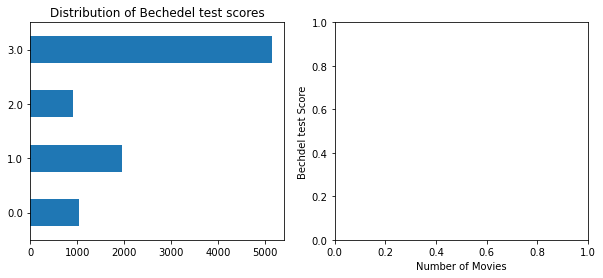

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
bechdel.bt_score.value_counts().sort_index().plot(kind = 'barh', ax=ax1)
plt.xlabel('Number of Movies')
plt.ylabel('Bechdel test Score')
ax1.set_title('Distribution of Bechedel test scores')


bechdel_cmu.bt_score.value_counts().sort_index().plot(kind = 'barh', ax=ax2)
plt.xlabel('Number of Movies')
plt.ylabel('Bechdel test Score')
ax2.set_title('Distribution of Bechedel test scores in cmu movie dataset')


NameError: name 'bechdel_cmu' is not defined

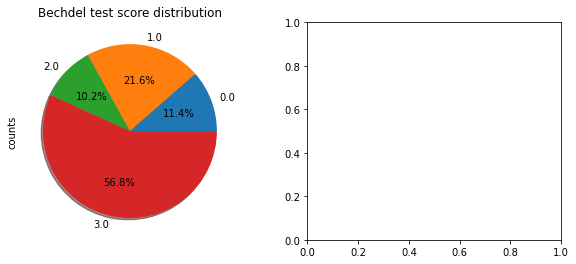

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
score_counts = bechdel.bt_score.value_counts().sort_index().rename_axis('bt_score').to_frame('counts')
score_counts.plot.pie(y='counts', title="Bechdel test score distribution", legend=False, autopct='%1.1f%%',  shadow=True, startangle=0, ax=ax1)

score_counts_cmu = bechdel_cmu.bt_score.value_counts().sort_index().rename_axis('bt_score').to_frame('counts')
score_counts_cmu.plot.pie(y='counts', title="Bechdel test score distribution in CMU dataset", legend=False, autopct='%1.1f%%',  shadow=True, startangle=0, ax=ax2)

From the pie charts and the bar plots we can see that the distribution are similar between the original Bechdel test dataset and the intersection of the cmu dataset. To have a better insight, we decide to perform analysis on the original dataset.

#### Change over the years

In [39]:
bechdel_year_mean = bechdel.groupby(['year'])['bt_score'].mean().to_frame().reset_index().sort_values('year')
bechdel_year_cnt = bechdel.year.value_counts().rename_axis('year').to_frame('counts').reset_index().sort_values('year')
bechdel_year = bechdel_year_cnt.merge(bechdel_year_mean, on='year')

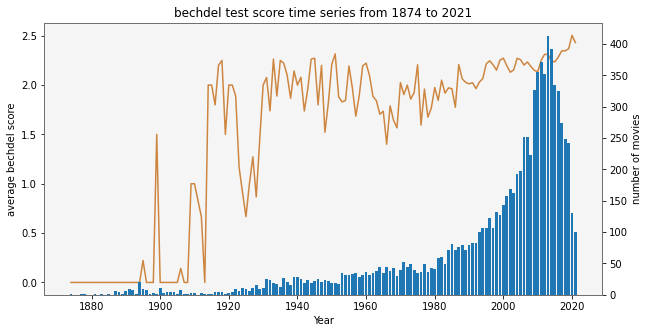

In [40]:
f, ax = plt.subplots(figsize=(10, 5))

g = plt.plot(bechdel_year['year'], bechdel_year['bt_score'], color = 'peru')

ax.grid(visible=False, axis='both')
ax.set_xlabel('Year')
ax.set_ylabel('average bechdel score')

ax2 = ax.twinx()
plt.bar(bechdel_year['year'], bechdel_year['counts'])
ax2.set_title('bechdel test score time series from 1874 to 2021')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('number of movies')

f.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax2.grid(visible=False)
ax2.spines['bottom'].set_color('0.5')
ax2.spines['top'].set_color('0.5')
ax2.spines['right'].set_color('0.5')
ax2.spines['left'].set_color('0.5')  



<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    The overall trend of the bechdel test score is increasing, which shows a better representation of the female characters in the film industry. However, there is a clear drop of the bechdel score right before 1930, this may due to the world war happened at the time that led to more movie about military and men. 
    Bechdel test score would be helpful to compare with other quantitive measure of the on/off screen measures of the CMU movie dataset.

## Sentiment analysis

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    For many trope descriptions the sentinel rating could be discussed, therefore the result is quite subjective. In addition, only 72-character types were provided, which is not a sufficient representation of the vast number of characters existing in the movies universe. Nevertheless, it can give a first representation of how characters are portrayed.

In [41]:
tvtropes = pd.merge(tvtropes, characters[['freebase_map_id','actor_gender','wiki_movie_id']],
                       left_on='freebase_map_id', right_on='freebase_map_id', how='left')

tvtropes_w_gender = tvtropes[['char_type', 'actor_gender']].groupby('char_type').agg('sum')
tvtropes_w_gender['female_ratio'] =tvtropes_w_gender['actor_gender'].apply(lambda x: get_gender_ratio(x,'F'))
tvtropes_w_gender = tvtropes_w_gender.query('female_ratio != 0').sort_values(by='female_ratio', ascending=False)
tvtropes_M = tvtropes[tvtropes['actor_gender']=='M']
tvtropes_F = tvtropes[tvtropes['actor_gender']=='F']

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In the following the 3 most appearing tvtropes within the dataset is shown.

In [42]:
f_movies = tvtropes_F.set_index(['char_type', 'sentiment'])
show_f = f_movies.groupby(['char_type','sentiment']).count()['wiki_movie_id'].nlargest(5)
display(show_f)

char_type         sentiment
dumb_blonde       -1           10
brainless_beauty  -1            7
chanteuse          0            6
final_girl         0            6
prima_donna       -1            6
Name: wiki_movie_id, dtype: int64

In [43]:
m_movies = tvtropes_M.set_index('char_type')
m_movies.groupby(['char_type','sentiment']).count()['wiki_movie_id'].nlargest(5)

char_type                    sentiment
crazy_jealous_guy            -1           25
corrupt_corporate_executive   0           23
byronic_hero                  1           17
psycho_for_hire               0           16
father_to_his_men             1           15
Name: wiki_movie_id, dtype: int64

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
One can see that the two most used female tropes have something to do with looks and is not intelligent. The top male trope is also negative, since the most important character trait is crazy and jealous, not showing a lot of character depth. Even though corrupt is usually associated with negative emotions, in this case it is evaluate as neutral since corrupt alone does not tell us more about a character’s depth.

In [44]:
print('Number of character types for female:\t {}\nNumber of character types for male:\t {}'.format(len(tvtropes_F.char_type.unique()), len(tvtropes_M.char_type.unique())))
print('Total number of female characters:\t {}\nTotal number of male characters:\t {}'.format(len(tvtropes_F), len(tvtropes_M)))
print('Percentage of unique characters in the female characters set:\t {}\nPercentage of unique characters in the male characters set:\t {}'.format(round(len(tvtropes_F.char_type.unique())/len(tvtropes_F),2), round(len(tvtropes_M.char_type.unique())/len(tvtropes_M),2)))

Number of character types for female:	 21
Number of character types for male:	 65
Total number of female characters:	 69
Total number of male characters:	 431
Percentage of unique characters in the female characters set:	 0.3
Percentage of unique characters in the male characters set:	 0.15


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
There are more male character types than female character types in the given dataset. The total number of male characters is also greater than the total number of female characters. The percentage of unique characters is greater for female characters.

In [45]:
print('\nSentiment score of female types: {}\nSentiment score of male types:\t {}'.format(round(tvtropes_F.sentiment.mean(),2), round(tvtropes_M.sentiment.mean(),3)))


Sentiment score of female types: -0.54
Sentiment score of male types:	 -0.007


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The sentiment towards female character is more negative than male. The sentiment is rated according to the complexness of a character, for example based based on intelligence.
Through the sentiment analysis we found out that the uniqueness of a character is higher for female characters, but the total number of characters is higher for male character. The male sentiment score for male characters is almost zero, meaning that there are equally simple characters than complex characters. The sentiment score of female characters is significantly lower, meaning that there are more simple characters. Therefore, one could conclude that even though female character differs more from each other, there are mostly simple. It is important to keep in mind that the dataset for this analysis is rather small, which might not represent the movies well.


## Quantification of gender inequality
[Back to table of contents](#ToC)

###  Female ratio 
#### Female ratio in cast

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The number of actress versus actor can reflect gender equality. Since the number of movies is not the same throughout the years, the ratio of female actress per year is computed.
However, some years only contain very few movies (e.g., at the very beginning stage of movie industry). Thus, we first need to filter out those years that have extremely few movies.

In [46]:
# first check the distribution of movies numbers in each year
characters_by_year = characters.copy()
characters_by_year = characters_by_year[~pd.isna(characters_by_year['release_date'])] # drop NaN release date
characters_by_year['release_date'] = pd.to_datetime(characters_by_year['release_date']) # transform to datetime format
characters_by_year['release_year'] = characters_by_year['release_date'].dt.to_period('Y') # create year column
characters_by_year['release_year'] = characters_by_year['release_year'].astype(str)
year_movie_count = characters_by_year.groupby('release_year')['wiki_movie_id'].count().reset_index()
year_movie_count['movie_count'] = year_movie_count['wiki_movie_id']# rename column
year_movie_count = year_movie_count[['release_year','movie_count']] # only keep necessary columns

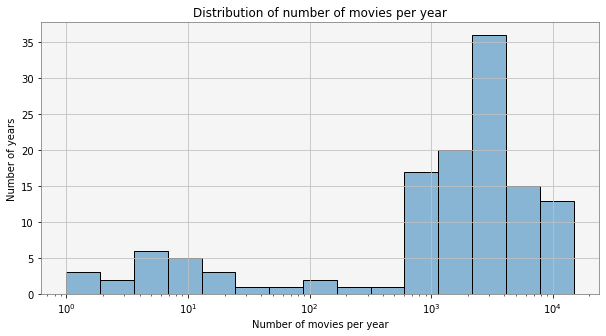

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
m = sns.histplot(year_movie_count, log_scale=True).set_title('Distribution of number of movies per year')
plt.xlabel('Number of movies per year')
plt.ylabel('Number of years')
plt.legend([],[], frameon=False)

ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
From the histogram, we can see that there are a few years where the number of movies produced is very little. By  filtering out certain years with extremely few movies (under 50 movies) we avoid a skewed computation of female ratio.

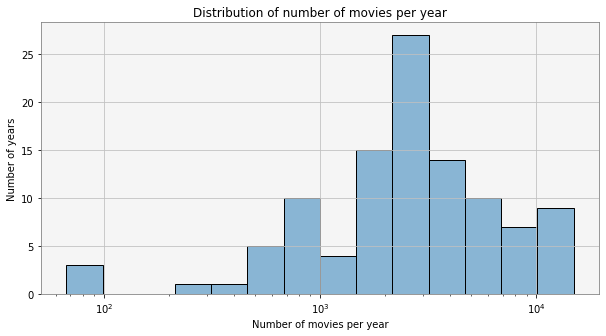

In [48]:
# filter out years with extremely few movies
year_movie_count = year_movie_count[year_movie_count['movie_count']>=50] # keep years with more than 50 movies
year_list= year_movie_count['release_year'] # create a list containing selected years
characters_by_year = characters_by_year[characters_by_year['release_year'].isin(year_list)]

fig, ax = plt.subplots(figsize=(10, 5))
m = sns.histplot(year_movie_count, log_scale=True).set_title('Distribution of number of movies per year')
plt.xlabel('Number of movies per year')
plt.ylabel('Number of years')
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend([],[], frameon=False)

In [49]:
female_ratio_by_year = characters_by_year.groupby('release_year').apply(lambda x: get_gender_ratio(x, 'F')).reset_index() # compute female ratio of each year
female_ratio_by_year['female_ratio'] = female_ratio_by_year[0] # rename column
female_ratio_by_year=female_ratio_by_year[['release_year','female_ratio']] # keep only necessary columns

male_ratio_by_year = characters_by_year.groupby('release_year').apply(lambda x: get_gender_ratio(x, 'M')).reset_index() # compute male ratio of each year
male_ratio_by_year['male_ratio'] = male_ratio_by_year[0] # rename column
male_ratio_by_year=male_ratio_by_year[['release_year','male_ratio']] # keep only necessary columns

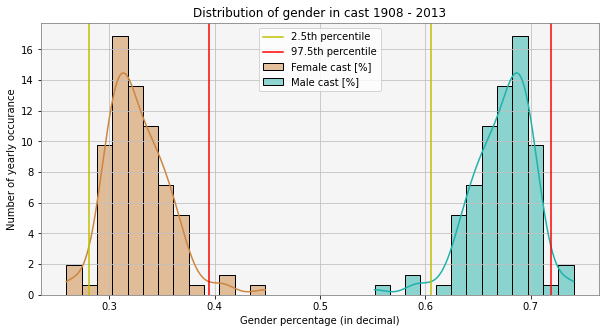

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.histplot(female_ratio_by_year.female_ratio.values, kde=True, stat='density', color = 'peru', label='Female cast [%]')
lower = np.percentile(female_ratio_by_year.female_ratio.values, 2.5)
upper = np.percentile(female_ratio_by_year.female_ratio.values, 97.5)
plt.axvline(x=lower, ymin=0, ymax=1,c='y')
plt.axvline(x=upper, ymin=0, ymax=1,c='r')

ax = sns.histplot(male_ratio_by_year.male_ratio.values, kde=True, stat='density', color = 'lightseagreen',label='Male cast [%]')
lower = np.percentile(male_ratio_by_year.male_ratio.values, 2.5)
upper = np.percentile(male_ratio_by_year.male_ratio.values, 97.5)
plt.axvline(x=lower, ymin=0, ymax=1,label='2.5th percentile',c='y')
plt.axvline(x=upper, ymin=0, ymax=1,label='97.5th percentile',c='r')

ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

plt.legend(loc='upper center', facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
leg = plt.legend()
leg.get_frame().set_facecolor('white')
plt.xlabel("Gender percentage (in decimal)")
plt.ylabel("Number of yearly occurance")
plt.title("Distribution of gender in cast 1908 - 2013")
plt.show()

In [51]:
# Interactive plot depending on time
def gender_distribution(bound):
    lower_bound = bound[0]
    upper_bound = bound[1]
    title = f'Distribution of gender in cast {lower_bound} - {upper_bound}'
    female_ratio_display = female_ratio_by_year[(female_ratio_by_year['release_year'].astype(int)>= lower_bound) & (female_ratio_by_year['release_year'].astype(int)<= upper_bound)]
    male_ratio_display = male_ratio_by_year[(male_ratio_by_year['release_year'].astype(int)>= lower_bound) & (male_ratio_by_year['release_year'].astype(int)<= upper_bound)]

    ax = sns.histplot(female_ratio_display.female_ratio.values, kde=True, stat='density', color = 'peru', label='Female cast [%]')
    lower = np.percentile(female_ratio_display.female_ratio.values, 2.5)
    upper = np.percentile(female_ratio_display.female_ratio.values, 97.5)
    plt.axvline(x=lower, ymin=0, ymax=1,c='y')
    plt.axvline(x=upper, ymin=0, ymax=1,c='r')
    sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'})
    ax = sns.histplot(male_ratio_display.male_ratio.values, kde=True, stat='density', color = 'lightseagreen',label='Male cast [%]')
    lower = np.percentile(male_ratio_display.male_ratio.values, 2.5)
    upper = np.percentile(male_ratio_display.male_ratio.values, 97.5)
    plt.axvline(x=lower, ymin=0, ymax=1,label='2.5th percentile',c='y')
    plt.axvline(x=upper, ymin=0, ymax=1,label='97.5th percentile',c='r')

    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    leg.get_frame().set_facecolor('white')
    plt.xlabel("Gender percentage")
    plt.ylabel("Number of yearly occurance")
    plt.title(title)


# Widget definition
select_period = widgets.Dropdown(
    options=[('1908 - 1935', [1908,1935]), ('1935 - 1945', [1935,1945]), ('1945 - 1990', [1945,1990]), ('1990 - 2013', [1990, 2013]), ('Average of total dataset', [1908,2013])],
    value= [1908,2013],
    description='Period:'
)

widgets.interactive(gender_distribution, bound=select_period)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1908, 1935]), ('1935 …

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    In the plot above we see the distribution of gender ratio from 1908 to 2013. It can be seen that there are always significantly more males than females. The distributions are looks normal distributed with a slight right skew for female ratio/ left skew for male ratio. This visualizes the inequality regarding gender ratio in the cast.

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In order to see if there is a improvement with time, a temporal flutuation of female ratio in cast from 1908 to 2013 is computed. Since we took out the years where the number of movies is under a certain threshhold, we add a new release_year column where no year was taken out. This ensures that the time axis is not skewed.

In [52]:
time_series =  pd.DataFrame({'release_year':np.arange(1888, 2017,1)})
time_series['release_year'] = time_series['release_year'].astype(str)
female_ratio_by_year['release_year'] = female_ratio_by_year['release_year'].astype(str)
year_movie_count['release_year'] =year_movie_count['release_year'].astype(str)

In [53]:
female_ratio_ts = time_series.merge(female_ratio_by_year, how = 'left', on='release_year').reset_index(drop=True)
movie_count_ts = time_series.merge(year_movie_count, how = 'left', on='release_year').reset_index(drop=True)

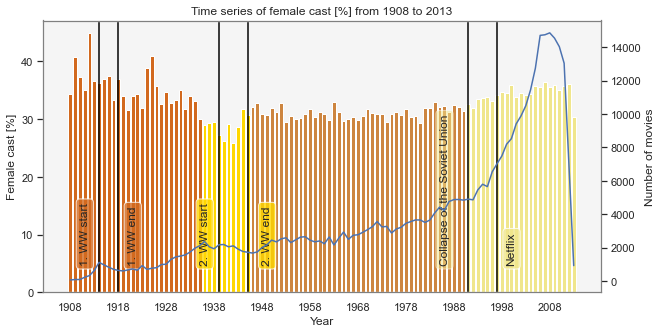

In [54]:
f, ax = plt.subplots(figsize=(10, 5))


colors = []
for x in movie_count_ts['release_year'].astype(int):
    if x <= 1935:
        colors.append('chocolate')
    elif (x > 1935) & (x <=1945):
        colors.append('gold')
    elif ((x > 1945) & (x <=1990)):
        colors.append('peru')
    else: 
        colors.append('khaki')

g = plt.bar(female_ratio_ts['release_year'], female_ratio_ts['female_ratio']*100, color = colors)
ax.grid(visible=False, axis='both')

ax.set_xlabel('Year')
ax.set_ylabel('Female cast [%]')

plt.axvline(x= '1914', color='black')
plt.text('1910', 5, '1. WW start', rotation=90, bbox=dict(facecolor='chocolate', alpha=0.8, boxstyle='round'))
plt.axvline(x= '1918', color='black')
plt.text('1920', 5, '1. WW end', rotation=90, bbox=dict(facecolor='chocolate', alpha=0.8, boxstyle='round'))
plt.axvline(x= '1939', color='black')
plt.text('1935', 5, '2. WW start', rotation=90, bbox=dict(facecolor='gold', alpha=0.8, boxstyle='round'))
plt.axvline(x= '1945', color='black')
plt.text('1948', 5, '2. WW end', rotation=90, bbox=dict(facecolor='gold', alpha=0.8, boxstyle='round'))
plt.axvline(x= '1991', color='black') 
plt.text('1985', 5, 'Collapse of the Soviet Union', rotation=90, bbox=dict(facecolor='khaki',alpha=0.5, boxstyle='round'))
plt.axvline(x= '1997', color='black') 
plt.text('1999', 5, 'Netflix', rotation=90, bbox=dict(facecolor='khaki', alpha=0.8, boxstyle='round'))

ax2 = ax.twinx()
plt.plot(movie_count_ts['release_year'],movie_count_ts['movie_count'])
ax2.set_title('Time series of female cast [%] from 1908 to 2013')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylabel('Number of movies')

f.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax2.grid(visible=False)
ax2.spines['bottom'].set_color('0.5')
ax2.spines['top'].set_color('0.5')
ax2.spines['right'].set_color('0.5')
ax2.spines['left'].set_color('0.5')  


for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept 
        label.set_visible(True)
    else:
        label.set_visible(False)

#plt.savefig('Time_series.png', dpi=300)

In [55]:
female_ratio_by_year['release_year'] = female_ratio_by_year['release_year'].astype(int)
part_0 = female_ratio_by_year[female_ratio_by_year['release_year']<=1935]
part_1 = female_ratio_by_year[(female_ratio_by_year['release_year']>=1935) & (female_ratio_by_year['release_year']<=1945)]
part_2 = female_ratio_by_year[(female_ratio_by_year['release_year']>=1945) & (female_ratio_by_year['release_year']<=1990)]
part_3 = female_ratio_by_year[(female_ratio_by_year['release_year']>=1990) & (female_ratio_by_year['release_year']<=2013)]

print("Female cast ratio")
print("Time\t \tVariance \t \t mean")
print(f"1908-1935 \t{ round(part_0['female_ratio'].var(),4) } \t\t\t{round(part_0['female_ratio'].mean(),3)}")
print(f"1935-1945 \t{ round(part_1['female_ratio'].var(),4) } \t\t\t{round(part_1['female_ratio'].mean(),3)}")
print(f"1945-1990 \t{ round(part_2['female_ratio'].var(),4) } \t\t\t{round(part_2['female_ratio'].mean(),3)}")
print(f"1990-2013 \t{ round(part_3['female_ratio'].var(),4) } \t\t\t{round(part_3['female_ratio'].mean(),3)}")

Female cast ratio
Time	 	Variance 	 	 mean
1908-1935 	0.001 			0.353
1935-1945 	0.0003 			0.289
1945-1990 	0.0001 			0.311
1990-2013 	0.0002 			0.343


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
As one can see the fluctuation is higher in in the begining, which can be explained by the fewer amount of movies. In those cases outliers have a greater effect. <br> 
    Between 1935-1945 it decreases to the min value. Between 1945-1990 the value is the most constant and from 1990 on the value slowely increases. In 2013 the value is unexcpected small which could be explained by the much smaller number of movies produced compared to the previous years. Therefore this value was taken out as an outlier.
   

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In order to compute a regression model, the first two periods are not considered since they donnot show an increase of female ratio and thus does not represent the current trend. Based on the figure above we can see that the relationship is not linearly, therefore a polynomial regression has to be applied. To find the best degree, cross validation is implemented. Without this, there is a danger of overfitting.

In [56]:
female_ratio_by_year = female_ratio_by_year[female_ratio_by_year['release_year'].astype(int)<2013]

In [57]:
# Extract wanted timeframe
movie_count_model = movie_count_ts[(movie_count_ts['release_year'].astype(int) >= 1945) & (movie_count_ts['release_year'].astype(int) != 2013)]
female_ratio_ts_model = female_ratio_ts[(female_ratio_ts['release_year'].astype(int) >= 1945)&(movie_count_ts['release_year'].astype(int) != 2013)]

In [58]:
new_female_ratio_ts = female_ratio_ts_model[~female_ratio_ts_model['female_ratio'].isna()]

X = np.array(new_female_ratio_ts['release_year']).reshape(-1, 1) # needed because we only have one single feature
y = new_female_ratio_ts['female_ratio']
random_state = 2
min_deg = crossvalidate_degree(X, y, 5)

Best degree 2 with RMSE 0.009599493675997139


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Depending on the random state of splitting into train and test data the best degrees varies between 2 to 10. The reason behind this big fluctuation stems from the small size of the data (From 1945 to 2016, where some years contain NaN values). <br>
A polynomial degree of 2 was chosen because we think that once the subject of gender gap is given sufficient attention the momentum will quickly come and the other movies will follow. 


In [59]:
# Build model
degree = 2
coeff = np.polyfit(new_female_ratio_ts['release_year'].astype(int), np.array(new_female_ratio_ts['female_ratio']),degree)  # x^2+x+c
yn = np.poly1d(coeff)

projection = np.arange(1945,2150,1)
y_project = yn(projection)

In [60]:
index_equality = np.where(y_project>= 0.5)
year_equality = projection[index_equality][0]
print(f'In year {year_equality} the female cast ratio is equivalent to the male cast ratio')

In year 2050 the female cast ratio is equivalent to the male cast ratio


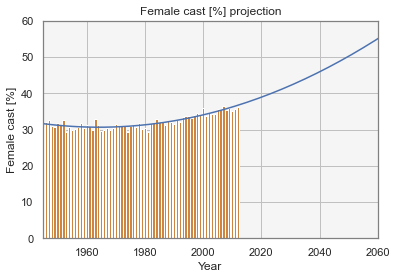

In [61]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax.set_xlim([1945, 2060])
ax.set_ylim([0, 60])
ax.bar(new_female_ratio_ts['release_year'].astype(int), new_female_ratio_ts['female_ratio']*100, color = 'peru')
ax.plot(projection, y_project*100, color="C0")
ax.set_title('Female cast [%] projection')
ax.set_xlabel('Year')
ax.set_ylabel('Female cast [%]')
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
#plt.savefig('Time_series_prediction.png', dpi=300)

In [62]:
year_index = np.where(projection == 2022)
f_ratio_projected = np.round(y_project[year_index][0],3)
print(f'The projected female ratio for 2022 is {f_ratio_projected}.')

The projected female ratio for 2022 is 0.395.


In [219]:
def f_cast_ts(x_range):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax.set_xlim([x_range[0], x_range[1]])
    ax.set_ylim([0, 60])
    ax.bar(new_female_ratio_ts['release_year'].astype(int), new_female_ratio_ts['female_ratio']*100, color = 'peru')
    ax.plot(projection, y_project*100, color="C0")
    current_value = round(y_project[x_range[1]- 1945]*100,2)
    label_t = f'Female cast in {x_range[1]} is {current_value} %'
    plt.text(x_range[1]+7, 0.05, label_t, rotation=90)

    ax.set_title('Female cast [%] projection')
    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
        
    ax.set_xlabel('Year')
    ax.set_ylabel('Female cast [%]')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')   


time_window = widgets.IntRangeSlider(
    value=[1945, 2060],
    min=1945,
    max=2100,
    step=1,
    description='Time window:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

widgets.interactive(f_cast_ts, x_range=time_window)

interactive(children=(IntRangeSlider(value=(1945, 2060), continuous_update=False, description='Time window:', …

In [376]:
output_file("pictures/female_cast_projection.html")

slider = RangeSlider(
    value=[1945, 2060],
    start=1945,
    end=2100,
    step=1)


p = figure(width=900, height=600, title='Female cast [%] projection', x_range=(1945, 2060), y_range=(0, 60))
p.vbar(x=new_female_ratio_ts['release_year'].astype(int), top=new_female_ratio_ts['female_ratio']*100, color = 'peru')
p.line(projection, y_project*100, line_color='dodgerblue', line_width=3)

slider.js_link("value", p.x_range, "start", attr_selector=0)
slider.js_link("value", p.x_range, "end", attr_selector=1)

p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Female cast [%]'

current_value = round(y_project[2050 - 1945]*100, 2)
label = Label(x=2050, y=100, y_units='screen', text=f'Female cast in 2050 is {current_value} %', text_color='dodgerblue', angle=np.pi/2)
p.add_layout(label)

l = layout([slider], [p])
show(l)

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The model based on our data is compared to the study: 'It’s a Man’s (Celluloid) World'. We chose to compare the year 2020 instead of 2021 since 2021 data is impacted by the Covid pandemic. In the study female characters accounted for 38% of major characters compared to our 39.5% projection. (https://womenintvfilm.sdsu.edu/research/) 
  

In [127]:
n_movie = characters_by_year.groupby(['wiki_movie_id','release_year']).apply(lambda x: get_gender_ratio(x, 'F')).reset_index() # compute female ratio of each year
n_movie = n_movie.rename(columns={0: 'female_ratio'})

In [128]:
n_movie = n_movie[n_movie.release_year != '2013']

Text(0.5, 1.0, 'Distribution of female cast [%] 1908 - 2012')

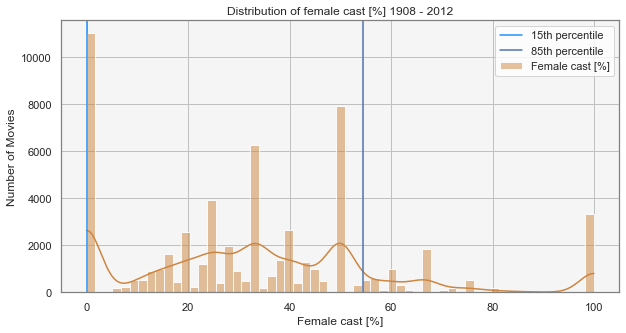

In [129]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.histplot(n_movie.female_ratio.values*100, kde=True, stat='count', color = 'peru', label='Female cast [%]')
lower = np.percentile(n_movie.female_ratio.values*100, 15)
upper = np.percentile(n_movie.female_ratio.values*100, 85)
plt.axvline(x=lower, ymin=0, ymax=1,c='dodgerblue', label = '15th percentile')
plt.axvline(x=upper, ymin=0, ymax=1,c='b', label = '85th percentile')

ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

plt.legend(loc='upper center', facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
leg = plt.legend()
leg.get_frame().set_facecolor('white')
plt.xlabel("Female cast [%]")
plt.ylabel("Number of Movies")
plt.title("Distribution of female cast [%] 1908 - 2012")
#plt.show()
#plt.savefig('movie_f_distribution.png', dbi = 300)

In [130]:
# Interactive plot depending on time
def f_nmovies(bound):
    lower_bound = bound[0]
    upper_bound = bound[1]
    title = f'Distribution of female cast percentage {lower_bound} - {upper_bound}'
    n_movie_display = n_movie[(n_movie['release_year'].astype(int)>= lower_bound) & (n_movie['release_year'].astype(int)<= upper_bound)]
   
    ax = sns.histplot(n_movie_display.female_ratio.values*100, kde=True, stat='count', color = 'peru', label='Female cast [%]')
    lower = np.percentile(n_movie_display.female_ratio.values*100, 15)
    upper = np.percentile(n_movie_display.female_ratio.values*100, 85)
    plt.axvline(x=lower, ymin=0, ymax=1,c='dodgerblue', label = '15th percentile')
    plt.axvline(x=upper, ymin=0, ymax=1,c='b', label = '85th percentile')
    sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'})
    
    plt.axvline(x= 50, color='black',linestyle = 'dashed')

    
    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    leg.get_frame().set_facecolor('white')
    plt.xlabel("Female cast [%]")
    plt.ylabel("Number of Movies")
    plt.title(title)
    


# Widget definition
select_period = widgets.Dropdown(
    options=[('1908 - 1935', [1908,1935]), ('1935 - 1945', [1935,1945]), ('1945 - 1990', [1945,1990]), ('1990 - 2013', [1990, 2012]), ('Average of total dataset', [1908,2012])],
    value= [1908,2012],
    description='Period:'
)

widgets.interactive(f_nmovies, bound=select_period)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1908, 1935]), ('1935 …

In [360]:
output_file("pictures/distribution_of_female_cast_percentage.html")

period = dict([('1908 - 1935', (1908,1935)), ('1935 - 1945', (1935,1945)), ('1945 - 1990', (1945,1990)), ('1990 - 2013', (1990, 2012)), ('Average of total dataset', (1908,2012))])

bound = (1908,2012)

def p_nmovies(bound):
    lower_bound = bound[0]
    upper_bound = bound[1]
    title = f'Distribution of female cast percentage {lower_bound} - {upper_bound}'
    p = figure(width=900, height=600, title=title)
    n_movie_display = n_movie[(n_movie['release_year'].astype(int)>= lower_bound) & (n_movie['release_year'].astype(int)<= upper_bound)]

    hist, edges = np.histogram(n_movie_display.female_ratio.values*100, density=False, bins=50)
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], color="orange", legend_label='Female cast [%]')

    lower = np.percentile(n_movie_display.female_ratio.values*100, 15)
    upper = np.percentile(n_movie_display.female_ratio.values*100, 85)
    l = Span(location=lower, dimension='height', line_color='dodgerblue', line_width=2)
    u = Span(location=upper, dimension='height', line_color='dodgerblue', line_width=2)
    m = Span(location=50, dimension='height', line_color='black', line_width=2,  line_dash="dashed")
    
    p.renderers.extend([l, m, u])

    p.xaxis.axis_label = 'Female cast [%]'
    p.yaxis.axis_label = 'Number of Movies'
    
    lower_label = Label(x=lower, y=500, y_units='screen', text='15th percentile', text_color='dodgerblue')
    upper_label = Label(x=upper, y=500, y_units='screen', text='85th percentile', text_color='dodgerblue')
    p.add_layout(lower_label)
    p.add_layout(upper_label)
    
    return p


tab = []

for t, bound in period.items():
    tab.append(Panel(child=p_nmovies(bound), title=t))
    
show(Tabs(tabs=tab))

### 2.1.2 Female ratio in directors

In [190]:
# load data
writers = pd.read_pickle('./data/writers.pickle')
directors = pd.read_pickle('./data/directors.pickle')

Let's first take a look at the overall female ratio in directors and writers!

In [191]:
female_ratio_directors = len(directors[directors['gender']=='F'])/len(directors)
female_ratio_writers = len(writers[writers['gender']=='F'])/len(writers)
print('The overall female ratio in directors and writers are {:.2f}'.format(female_ratio_directors),'and {:.2f}'.format(female_ratio_writers))

The overall female ratio in directors and writers are 0.15 and 0.21


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The overall female ratios are much lower than expected! Then we would like to know how ratios change across this long period in directors and writers. Is it getting better for women directors and writers? Let's investigate into directors first!

In [192]:
# merge dataframe by title to get release year 
def ffemale_ratio(s):
    female_count = len(s[s['gender']=='F'])
    return round((female_count/len(s)), 4)
directors.rename(columns={'title': 'movie_name'}, inplace=True)# rename columns to get the key
directors_by_year = pd.merge(directors,movies, on = 'movie_name')
directors_by_year=directors_by_year[['wiki_movie_id','movie_name','director_name','gender','release_date','countries', 'genres']] # keep only necessary columns
directors_by_year['release_date'] = pd.to_datetime(directors_by_year['release_date'])
directors_by_year['release_year'] = directors_by_year['release_date'].dt.to_period('Y') # create year column

In [193]:
# filter out years with extremely few movies 
directors_by_year['release_year'] = directors_by_year['release_year'].astype(str)
directors_by_year = directors_by_year[directors_by_year['release_year'].isin(year_list)]

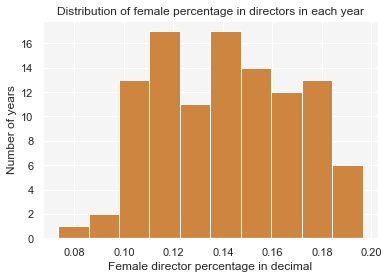

In [194]:
female_director_ratio_by_year = directors_by_year.groupby('release_year').apply(lambda x: ffemale_ratio(x)).reset_index()
female_director_ratio_by_year['female_ratio'] = female_director_ratio_by_year[0] # rename column
female_director_ratio_by_year=female_director_ratio_by_year[['release_year','female_ratio']] # keep only necessary columns
female_director_ratio_by_year.hist(color = 'peru')

ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')

plt.xlabel('Female director percentage in decimal')
plt.ylabel('Number of years')
plt.title('Distribution of female percentage in directors in each year')
plt.show()

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    The overall ratio is pretty low and not skewed, thus we don't use a logarithmic scale here. Now we got the final temporal flutuation of female ratio in directors from 1888 to 2016.

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In order to be able to interprete the female ratio of directors we analyzed the total women employement rate from: https://ourworldindata.org/female-labor-supply <br>
The variance of the time series is higher then expected. This stems from the fact that the number of countries varies between the Years. So if one country starts recording the female labor force, they can greatly influence the female emplyement ratio. In order to mitigate this, a fit to the ts is done.

In [195]:
f_employement = pd.read_csv('data/female-labor.csv', sep=',') #, names=char_cols, parse_dates=["release_date"], date_parser=lambda x: pd.to_datetime(x, errors="coerce"))

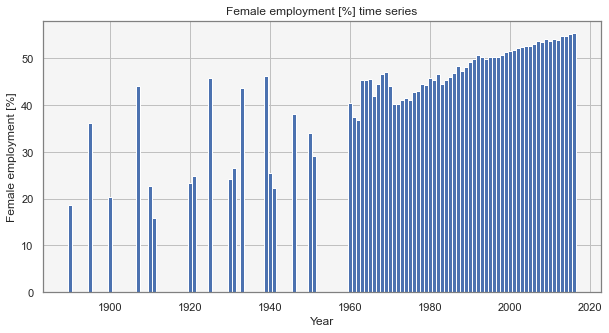

In [196]:
fig, ax = plt.subplots(figsize=(10, 5))
f_employement_year = f_employement.groupby('Year').agg('mean').reset_index()
f_employement_year['Female labor force'] = f_employement_year['Female labor force']/100
plt.bar(f_employement_year['Year'].astype(int), f_employement_year['Female labor force']*100)
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.xlabel('Year')
plt.ylabel('Female employment [%]')
plt.title('Female employment [%] time series')
plt.show()

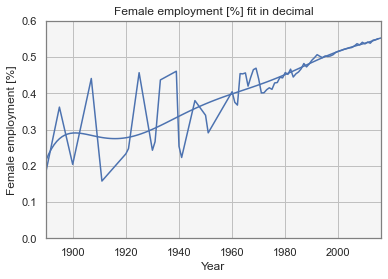

In [197]:
# Build model
degree = 10 # We're not afraid of overfitting in this case because we don't want to do any prediction.
coeff = np.polyfit(f_employement_year['Year'].astype(int), np.array(f_employement_year['Female labor force']),degree)  # x^2+x+c
yn_employement = np.poly1d(coeff)
time_employement = np.arange(f_employement_year['Year'].min(),f_employement_year['Year'].max(),1)
employement_fit = yn_employement(time_employement)

fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax.set_xlim([f_employement_year['Year'].min(), f_employement_year['Year'].max()])
ax.set_ylim([0, 0.6])
ax.plot(f_employement_year['Year'].astype(int), f_employement_year['Female labor force'])
ax.plot(time_employement, employement_fit, color="C0")
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_title('Female employment [%] fit in decimal')
ax.set_xlabel('Year')
ax.set_ylabel('Female employment [%]')
plt.show()

In [198]:
female_director_ratio_by_year[female_director_ratio_by_year['release_year'].astype(int)>= 2008]

,release_year,female_ratio
100,2008,0.1911
101,2009,0.1964
102,2010,0.1892
103,2011,0.1802
104,2012,0.1807
105,2013,0.1532


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We drop year 2013 because it looks very different to the previous years and as the last dataset it might not have been fully completed.

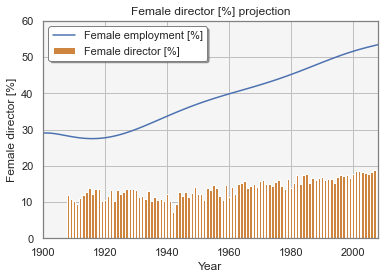

In [199]:
female_director_ratio_by_year = female_director_ratio_by_year[female_director_ratio_by_year['release_year'].astype(int)<2013]
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax.set_xlim([1900, 2008])
ax.set_ylim([0, 60])
ax.bar(female_director_ratio_by_year['release_year'].astype(int), female_director_ratio_by_year['female_ratio']*100, label = 'Female director [%]', color = 'peru')
ax.plot(time_employement, employement_fit*100, color="C0",label = 'Female employment [%]')
ax.set_title('Female director [%] projection')
ax.set_xlabel('Year')
ax.set_ylabel('Female director [%]')

ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend(facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
plt.show()

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We can see that the female employement rate for directors is significantly lower compared to the average female employement rate. <br>
Now we want to fit a linear regression model to see when equality will be reached.Again the best degree depends on the random state. Based on the same hypothesis above on how trends work, a degree of 2 is set.

In [200]:
# Drop Nan 
new_director_ratio_ts = female_director_ratio_by_year[~female_director_ratio_by_year['female_ratio'].isna()]

X = np.array(new_director_ratio_ts['release_year']).reshape(-1, 1) # needed because we only have one single feature
y = new_director_ratio_ts['female_ratio']*100
min_deg = crossvalidate_degree(X, y, random_state = 4)

Best degree 2 with RMSE 1.253483041256936


In [201]:
# Build model
degree = 2
coeff_dir = np.polyfit(new_director_ratio_ts['release_year'].astype(int), np.array(new_director_ratio_ts['female_ratio']),degree)  # x^2+x+c
yn_director = np.poly1d(coeff_dir)
end_projection = 2150
projection_director = np.arange(int(new_director_ratio_ts['release_year'].min()),end_projection,1)
y_project_director = yn_director(projection_director)

In [202]:
index_equality = np.where(y_project_director>= 0.5)
year_equality = projection_director[index_equality][0]
print(f'In year {year_equality} the female director ratio is equivalent to the male director ratio')

In year 2133 the female director ratio is equivalent to the male director ratio


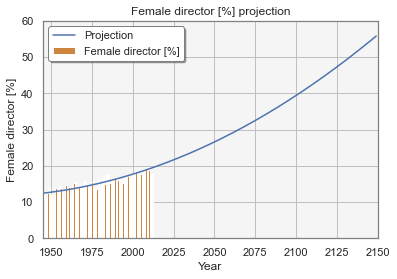

In [203]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax.set_xlim([1945, end_projection])
ax.set_ylim([0, 60])
ax.bar(new_director_ratio_ts['release_year'].astype(int), new_director_ratio_ts['female_ratio']*100, color = 'peru', label = 'Female director [%]')
ax.plot(projection_director, y_project_director*100, color="C0", label = 'Projection')
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_title('Female director [%] projection')
ax.set_xlabel('Year')
ax.set_ylabel('Female director [%]')
plt.legend(facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
plt.show()

In [204]:
def f_director_ts(mode):

    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    if mode == 'Projection until gender equality':
        ax.set_xlim([1945, 2150])
        ax.set_ylim([0, 60])
        ax.bar(new_director_ratio_ts['release_year'].astype(int), new_director_ratio_ts['female_ratio']*100, color = 'peru', label = 'Female director [%]')
        ax.plot(projection_director, y_project_director*100, color="C0", label = 'Projection')
        ax.grid(visible=True, color='silver')
    else:
        ax.set_xlim([1900, 2008])
        ax.set_ylim([0, 60])
        ax.bar(female_director_ratio_by_year['release_year'].astype(int), female_director_ratio_by_year['female_ratio']*100, label = 'Female director [%]', color = 'peru')
        ax.plot(time_employement, employement_fit*100, color="C0",label = 'Female employment [%]')
        
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    ax.set_title(mode)
    ax.set_xlabel('Year')
    ax.set_ylabel('Female director [%]')  
    plt.legend(facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)


analyzing_director = widgets.Dropdown(
    options=['Comparison with worldwide female employment rate', 'Projection until gender equality'],
    value='Comparison with worldwide female employment rate',
    description='Mode',
    disabled=False
)

widgets.interactive(f_director_ts, mode=analyzing_director)

interactive(children=(Dropdown(description='Mode', options=('Comparison with worldwide female employment rate'…

### 2.1.3 Female ratio in writers
Let's repeat the same procedure and see what happens to writers!

In [205]:
writers.rename(columns={'title': 'movie_name'}, inplace=True)# rename columns to get the key
writers_by_year = pd.merge(writers,movies, on = 'movie_name')
writers_by_year=writers_by_year[['movie_name','writer_name','gender','release_date','genres','countries']] # keep only necessary columns
writers_by_year['release_date'] = pd.to_datetime(writers_by_year['release_date'])
writers_by_year['release_year'] = writers_by_year['release_date'].dt.to_period('Y') # create year column

In [206]:
# filter out years with extremely few movies 
writers_by_year['release_year'] = writers_by_year['release_year'].astype(str)
writers_by_year = writers_by_year[writers_by_year['release_year'].isin(year_list)]

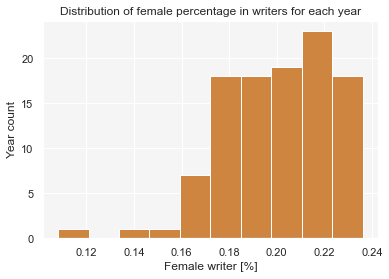

In [207]:
female_writer_ratio_by_year = writers_by_year.groupby('release_year').apply(lambda x: ffemale_ratio(x)).reset_index()
female_writer_ratio_by_year['female_ratio'] = female_writer_ratio_by_year[0] # rename column
female_writer_ratio_by_year=female_writer_ratio_by_year[['release_year','female_ratio']] # keep only necessary columns

sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white'})
female_writer_ratio_by_year.hist(color ='peru')
ax.grid(visible=True, color='silver')

plt.xlabel('Female writer [%]')
plt.ylabel('Year count')
plt.title('Distribution of female percentage in writers for each year')
plt.show()

Similarly,  we got the final temporal flutuation of female ratio in writers from 1888 to 2016.

In [208]:
female_writer_ratio_by_year[female_writer_ratio_by_year['release_year'].astype(int)>=2010]

,release_year,female_ratio
102,2010,0.2318
103,2011,0.2271
104,2012,0.2280
105,2013,0.2011


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We drop year 2013 because it looks very different to the previous years and as the last dataset it might not have been fully completed.

In [209]:
female_writer_ratio_by_year = female_writer_ratio_by_year[female_writer_ratio_by_year['release_year'].astype(int)<2013]

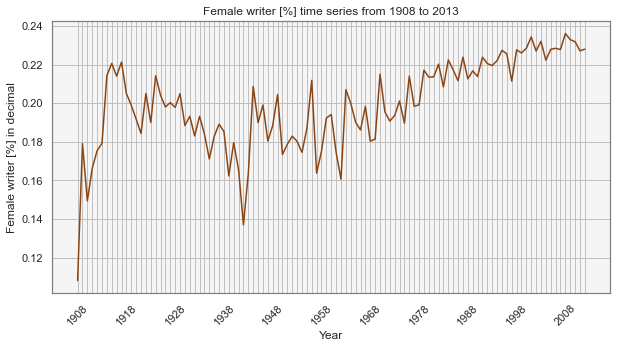

In [210]:
f, ax = plt.subplots(figsize=(10, 5))

g = sns.lineplot(data=female_writer_ratio_by_year ,x='release_year',y='female_ratio',color = 'saddlebrown')
g.set_title('Female writer [%] time series from 1908 to 2013')
g.tick_params(axis='x', rotation=45)
ax.grid(visible=True, color='silver')
f.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
ax.set_ylabel('Female writer [%] in decimal')
ax.set_xlabel('Year')

for ind, label in enumerate(g.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept 
        label.set_visible(True)
    else:
        label.set_visible(False)

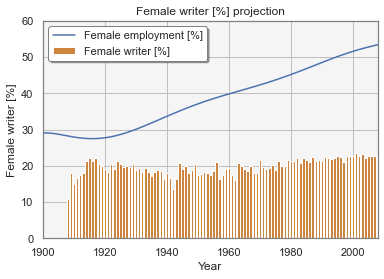

In [211]:
female_writer_ratio_by_year = female_writer_ratio_by_year[female_writer_ratio_by_year['release_year'].astype(int)<2013]
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax.set_xlim([1900, 2008])
ax.set_ylim([0, 60])
ax.bar(female_writer_ratio_by_year['release_year'].astype(int), female_writer_ratio_by_year['female_ratio']*100, label = 'Female writer [%]', color = 'peru')
ax.plot(time_employement, employement_fit*100, color="C0",label = 'Female employment [%]')
ax.set_title('Female writer [%] projection')
ax.set_xlabel('Year')
ax.set_ylabel('Female writer [%]')
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend(loc='upper left', facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
plt.show()

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We want to again predict when equality can be expected, this time with regard to female writer.

In [212]:
# Drop Nan 
female_writer_ratio_ts = female_writer_ratio_by_year[~female_writer_ratio_by_year['female_ratio'].isna()]

X = np.array(female_writer_ratio_ts['release_year']).reshape(-1, 1) # needed because we only have one single feature
y = female_writer_ratio_ts['female_ratio']
min_deg = crossvalidate_degree(X, y, random_state = 7)

Best degree 2 with RMSE 0.012412779893486065


In [213]:
# Build model
degree = 2
coeff = np.polyfit(female_writer_ratio_ts['release_year'].astype(int), np.array(female_writer_ratio_ts['female_ratio']),degree)  # x^2+x+c
yn = np.poly1d(coeff)

projection_writer = np.arange(1945,2150,1)
y_project_writer = yn(projection_writer)

In [214]:
index_equality = np.where(y_project_writer>= 0.5)
year_equality = projection_writer[index_equality][0]
print(f'In year {year_equality} the female writer ratio is equivalent to the male cast ratio')

In year 2127 the female writer ratio is equivalent to the male cast ratio


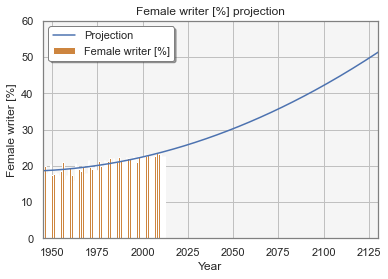

In [215]:
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax.set_xlim([1945, 2130])
ax.set_ylim([0, 60])
ax.bar(female_writer_ratio_by_year['release_year'].astype(int), female_writer_ratio_by_year['female_ratio']*100, label='Female writer [%]', color = 'peru')
ax.plot(projection_writer, y_project_writer * 100, color="C0", label = 'Projection')
ax.set_title('Female writer [%] projection')
ax.set_xlabel('Year')
ax.set_ylabel('Female writer [%]')
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend(loc='upper left', facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
plt.show()
    

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The female writer ratio is also significantly lower compared to the average female employement rate but higher to the female director ratio. <br>
Now we want to fit a linear regression model to see when equality will be reached.Again the best degree depends on the random state. Based on the same hypothesis above on how trends work, a degree of 2 is set.

[]

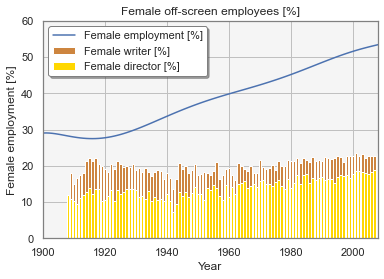

In [216]:
female_director_ratio_by_year = female_director_ratio_by_year[female_director_ratio_by_year['release_year'].astype(int)<2013]
fig=plt.figure()
ax=fig.add_subplot(111, label="1")
ax.set_xlim([1900, 2008])
ax.set_ylim([0, 60])
ax.bar(female_writer_ratio_by_year['release_year'].astype(int), female_writer_ratio_by_year['female_ratio']*100, label = 'Female writer [%]', color = 'peru')
ax.bar(female_director_ratio_by_year['release_year'].astype(int), female_director_ratio_by_year['female_ratio']*100, label = 'Female director [%]', color = 'gold')
ax.plot(time_employement, employement_fit*100, color="C0",label = 'Female employment [%]')
ax.set_title('Female off-screen employees [%]')
ax.set_xlabel('Year')
ax.set_ylabel('Female employment [%]')
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend(loc='upper left', facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
plt.plot()
    

In [217]:
def f_offscreen_ts(mode):

    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    if mode == 'Comparison with worldwide female employment rate':
        ax.set_xlim([1900, 2008])
        ax.set_ylim([0, 60])
        ax.bar(female_writer_ratio_by_year['release_year'].astype(int), female_writer_ratio_by_year['female_ratio']*100, label = 'Female writer [%]', color = 'peru')
        ax.bar(female_director_ratio_by_year['release_year'].astype(int), female_director_ratio_by_year['female_ratio']*100, label = 'Female director [%]', color = 'gold')
        ax.plot(time_employement, employement_fit*100, color="C0",label = 'Female employment [%]')
    elif mode == 'Female writer projection':
        ax.set_xlim([1945, 2130])
        ax.set_ylim([0, 60])
        ax.bar(female_writer_ratio_by_year['release_year'].astype(int), female_writer_ratio_by_year['female_ratio']*100, label = 'Female writer [%]', color = 'peru')
        ax.bar(female_director_ratio_by_year['release_year'].astype(int), female_director_ratio_by_year['female_ratio']*100, label = 'Female director [%]', color = 'gold')
        ax.plot(projection_writer, y_project_writer*100, color="saddlebrown", label = 'Projection writer')  
    else: 
        ax.set_xlim([1945, 2150])
        ax.set_ylim([0, 60])
        ax.bar(female_writer_ratio_by_year['release_year'].astype(int), female_writer_ratio_by_year['female_ratio']*100, label = 'Female writer [%]', color = 'peru')
        ax.bar(female_director_ratio_by_year['release_year'].astype(int), female_director_ratio_by_year['female_ratio']*100, label = 'Female director [%]', color = 'gold')
        ax.plot(projection_director, y_project_director*100, color="orange", label = 'Projection director')     
    
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    ax.set_title(mode)
    ax.set_xlabel('Year')
    ax.set_ylabel('Female employment [%]')  
    plt.legend(facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)


analyzing_offscreen = widgets.Dropdown(
    options=['Comparison with worldwide female employment rate', 'Female writer projection', 'Female director projection'],
    value='Comparison with worldwide female employment rate',
    description='Mode',
    disabled=False
)

widgets.interactive(f_offscreen_ts, mode=analyzing_offscreen)

interactive(children=(Dropdown(description='Mode', options=('Comparison with worldwide female employment rate'…

In [218]:
def f_cast_ts(x_range):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax.set_xlim([x_range[0], x_range[1]])
    ax.set_ylim([0, 60])
    ax.bar(new_female_ratio_ts['release_year'].astype(int), new_female_ratio_ts['female_ratio']*100, color = 'peru')
    ax.plot(projection, y_project*100, color="C0")
    current_value = round(y_project[x_range[1]- 1945]*100,2)
    label_t = f'Female cast in {x_range[1]} is {current_value} %'
    plt.text(x_range[1]+7, 0.05, label_t, rotation=90)

    ax.set_title('Female cast [%] projection')
    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
        
    ax.set_xlabel('Year')
    ax.set_ylabel('Female cast [%]')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')   


time_window = widgets.IntRangeSlider(
    value=[1945, 2060],
    min=1945,
    max=2100,
    step=1,
    description='Time window:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

widgets.interactive(f_cast_ts, x_range=time_window)

interactive(children=(IntRangeSlider(value=(1945, 2060), continuous_update=False, description='Time window:', …

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Although the female ratio in directors and writers gradually increases during a century, the female proportion is somehow still unsatisfactory, as it accounts for less than a quarter. Men are dominant in movie production, which is even worse than what happens in cast.
Meanwhile, we also noticed that around 1938, all the female ratio in cast, directors and writers experienced dramatic decline. It's possibly due to second world war when women tend to have less chance in their movie career in wartime, compared to peacetime. Surprisingly this is not mirrored in the general female employment rate, where a decrease is seen around 19015, when the first worldwar happened.

Compare to worldwide woman force percentage 

https://fredblog.stlouisfed.org/2021/03/women-in-the-labor-force/?utm_source=series_page&utm_medium=related_content&utm_term=related_resources&utm_campaign=fredblog

###  2.2 Age gap between males and females in cast

In [220]:
age = characters.copy()
age = age[age['actor_age_at_release']>0]# keep only positive values
age['release_year'] = age['release_date'].dt.to_period('Y') # create year column

In [221]:
age_distr = age.copy()
age_distr['release_year'] = age_distr['release_year'].astype(str).astype(int)

In [222]:
def age_distribution(bound):
    lower_bound = bound[0]
    upper_bound = bound[1]
    title = f'Age distribution of cast {lower_bound} - {upper_bound}'
    age_displ = age_distr[((age_distr['release_year']>= lower_bound) & (age_distr['release_year']<= upper_bound))]
    female_chara = age_displ[age_displ['actor_gender']=='F'].dropna()
    male_chara = age_displ[age_displ['actor_gender']=='M'].dropna()

    fig, ax = plt.subplots(figsize=(10, 5))

    a_heights, a_bins = np.histogram(female_chara['actor_age_at_release'])
    b_heights, b_bins = np.histogram(male_chara['actor_age_at_release'], bins=a_bins)
    width = (a_bins[1] - a_bins[0])/3
    ax.bar(a_bins[:-1], a_heights, width=width, facecolor='peru',label='Female cast [%]')
    legend_f = 'Mean age of actresses: ' + str(round(female_chara['actor_age_at_release'].mean(),2))
    legend_m =  'Mean age of actors: ' + str(round(male_chara['actor_age_at_release'].mean(),2))                       
    ax.axvline(female_chara['actor_age_at_release'].mean(), color='saddlebrown', linestyle='dashed', linewidth=1.5, label = legend_f)
    ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='lightseagreen',label='Male cast [%]')
    ax.axvline(male_chara['actor_age_at_release'].mean(), color='teal', linestyle='dashed', linewidth=1.5,label = legend_m)
    
    
    plt.title(title)
    ax.set_ylabel('Number of Actor respective Actress')
    ax.set_xlabel('Age')
    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    


select_period = widgets.Dropdown(
    options=[('1908 - 1935', [1908,1935]), ('1935 - 1945', [1935,1945]), ('1945 - 1900', [1945,1990]), ('1900 - 2016', [1990,2016]), ('Average of total dataset', [1908,2016])],
    value= [1908,2016],
    description='Period:',
)

widgets.interactive(age_distribution, bound=select_period)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1908, 1935]), ('1935 …

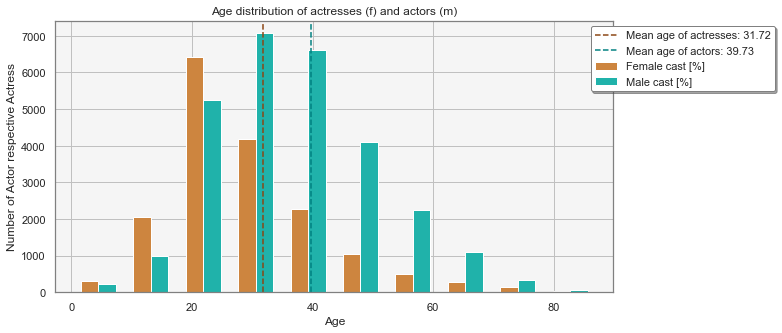

In [223]:
# Static image
# age gap between actresses and actors
female_chara = age[age['actor_gender']=='F'].dropna()
male_chara = age[age['actor_gender']=='M'].dropna()
np.random.seed(0)
fig, ax = plt.subplots(figsize=(10, 5))
a_heights, a_bins = np.histogram(female_chara['actor_age_at_release'])
b_heights, b_bins = np.histogram(male_chara['actor_age_at_release'], bins=a_bins)
width = (a_bins[1] - a_bins[0])/3
ax.bar(a_bins[:-1], a_heights, width=width, facecolor='peru',label='Female cast [%]')
legend_f = 'Mean age of actresses: ' + str(round(female_chara['actor_age_at_release'].mean(),2))
legend_m =  'Mean age of actors: ' + str(round(male_chara['actor_age_at_release'].mean(),2))                       
ax.axvline(female_chara['actor_age_at_release'].mean(), color='saddlebrown', linestyle='dashed', linewidth=1.5, label = legend_f)
ax.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='lightseagreen',label='Male cast [%]')
ax.axvline(male_chara['actor_age_at_release'].mean(), color='teal', linestyle='dashed', linewidth=1.5,label = legend_m)
    
    
plt.title('Age distribution of actresses (f) and actors (m)')
ax.set_ylabel('Number of Actor respective Actress')
ax.set_xlabel('Age')
ax.grid(visible=True, color='silver')
fig.patch.set_facecolor('white')
ax.set_facecolor('whitesmoke')
ax.spines['bottom'].set_color('0.5')
ax.spines['top'].set_color('0.5')
ax.spines['right'].set_color('0.5')
ax.spines['left'].set_color('0.5')
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
From the age distribution plot, we can see that the average age of actors is around 40 years old, which is 8 years elder than actresses (a huge gap!). Also, age distribution of actors is closer to normal distribution, while actresses declines dramatically once they are no longer at their 'best age'. Women tend to have shorter career in acting. It's also noteworthy that for actors at the same age, men are dominant after 30 years old. It implies that good looks may be more valued for actresses than actors in movie industry.

###  2.3 Cast distribution in different domains


#### 2.3.1 Genre

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Only the years in which at least 50 movies have been produced are considered. Through merge with characters the gender of the cast is obtained but some entries get lost. Therefore, a threshold of 50 is set to ensure that enough movies are within a genre. 
    

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In milestone 2 we found out that the popularity of different genres varies with time. Therefore a gender ratio time series of the top 30 genre is impossible to show in a clean way.<br>     
In the chapter above we analysed the gender ratio with respect to time. We found 4 time periods that show a certain pattern. Therefore we want to find out what genres are most popular during that period. Since only a small fraction of the dataset misses the release date we dropped those values.

In [224]:
movie_genres_copy = movie_genres.copy()
movie_genres_by_year = movie_genres_copy[~pd.isna(movie_genres_copy['release_date'])] # drop NaN release date
movie_genres_by_year['release_date'] = pd.to_datetime(movie_genres_by_year['release_date']) # transform to datetime format
movie_genres_by_year['release_year'] = movie_genres_by_year['release_date'].dt.to_period('Y') # create year column
movie_genres_by_year['release_year'] = movie_genres_by_year['release_year'].astype(str)
movie_genres_by_year['release_year'] = movie_genres_by_year['release_year'].astype(int)

movie_genres_0 = movie_genres_by_year[movie_genres_by_year['release_year']<=1935]
movie_genres_1 = movie_genres_by_year[(movie_genres_by_year['release_year']>=1935) & (movie_genres_by_year['release_year']<=1945)]
movie_genres_2 = movie_genres_by_year[(movie_genres_by_year['release_year']>=1945) & (movie_genres_by_year['release_year']<=1990)]
movie_genres_3 = movie_genres_by_year[(movie_genres_by_year['release_year']>=1990)]

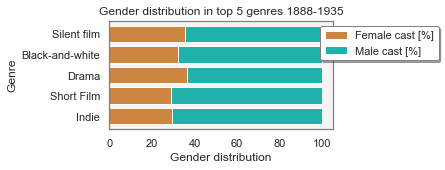

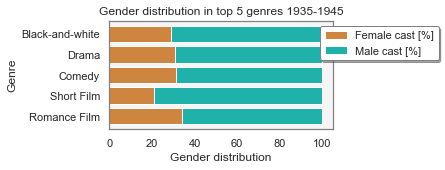

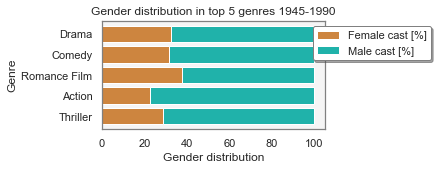

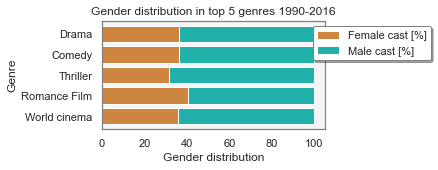

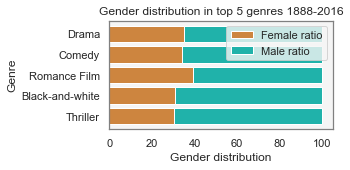

In [225]:
# Save for interactive plot
genre_gender_interactive = []

# get top 5 genres of all movie
for movie_genres, title in zip((movie_genres_0, movie_genres_1,movie_genres_2,movie_genres_3,movie_genres_by_year),('Gender distribution in top 5 genres 1888-1935','Gender distribution in top 5 genres 1935-1945','Gender distribution in top 5 genres 1945-1990','Gender distribution in top 5 genres 1990-2016','Gender distribution in top 5 genres 1888-2016')):
    top5_genres = movie_genres['genres'].value_counts()[:5].to_frame().reset_index().rename(columns={"index": "genres", "genres": "counts"})
    
    character_genres = pd.merge(left = characters, right = movie_genres, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
    genre_gender = character_genres[character_genres.genres.isin(top5_genres.genres.to_list())][['actor_gender', 'genres']].groupby('genres').agg('sum')
    genre_gender['female_ratio'] = genre_gender['actor_gender'].apply(lambda x: get_gender_ratio(x, "F"))
    genre_gender = genre_gender.drop(columns=['actor_gender']).reset_index()
    genre_gender = pd.merge(left = genre_gender, right = top5_genres, on='genres', how='left')
    genre_gender = genre_gender.sort_values(by='counts', ascending=False).reset_index()
    genre_gender['male_ratio'] = 1-genre_gender['female_ratio']
    genre_gender_interactive.append(genre_gender)
    
    fig, ax = plt.subplots(figsize=(4, 2))
    genre_gender_plot = genre_gender[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(genre_gender_plot['genres'], genre_gender_plot['female_ratio']*100, color="peru", label = 'Female cast [%]')
    b2 = ax.barh(genre_gender_plot['genres'], genre_gender_plot['male_ratio']*100,  left= genre_gender_plot['female_ratio']*100 , color="lightseagreen", label = 'Male cast [%]')

    plt.title(title)
    
    ax.set_ylabel('Genre')
    ax.set_xlabel('Gender distribution')
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    
ax.legend([b1, b2], ["Female ratio", "Male ratio"], loc="upper right")
plt.show()

In [226]:
def top_genre_distribution(info_genre):
    lower_bound = info_genre[0]
    upper_bound = info_genre[1]
    genre_gender = info_genre[2]
    title = f'Gender distribution in top 5 genres {lower_bound} - {upper_bound}'
    

    fig, ax = plt.subplots(figsize=(10, 5))
    genre_gender_plot = genre_gender[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(genre_gender_plot['genres'], genre_gender_plot['female_ratio']*100, color="peru", label = 'Female cast [%]')
    b2 = ax.barh(genre_gender_plot['genres'], genre_gender_plot['male_ratio']*100,  left= genre_gender_plot['female_ratio']*100 , color="lightseagreen", label = 'Male cast [%]')

    plt.title(title)
    
    ax.set_ylabel('Genre')
    ax.set_xlabel('Gender distribution')
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    # End
    

top_genre = widgets.Dropdown(
    options=[('1888 - 1935', [1888,1935,genre_gender_interactive[0]]), ('1935 - 1945', [1935,1945,genre_gender_interactive[1]]), ('1945 - 1900', [1945,1900,genre_gender_interactive[2]]),('1900 - 2016', [1990,2016, genre_gender_interactive[3]]), ('Average of total dataset', [1888,2016,genre_gender_interactive[4]])],
    value= [1888,2016,genre_gender_interactive[4]],
    description='Period:',
)

widgets.interactive(top_genre_distribution, info_genre = top_genre)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1888 - 1935', [1888, 1935,    index …

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
For all periods the top 5 genres have a higher male cast ratio. We can see that in the period 1935-1945 where the female ratio is especially low, the genre short film is quite popular with a very low female ratio. The most popular genres between 1945-1990 and 1990-2013 are almost equal. So one could hypothise that the female ratio rose because society became more aware of gender inequality on screen. 
Based on the genre Drama that is a top genre in all time periods we can see that the female ratio doesn't constantly rise with time, which is in accordance with the analysis in the previous chapter. 
    In addition to the gender ratio of the most popular genres we are also interested in which genres female and male actor appear most often. 

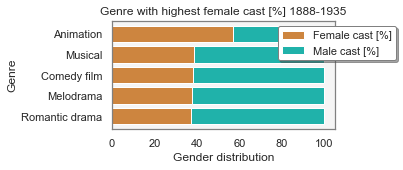

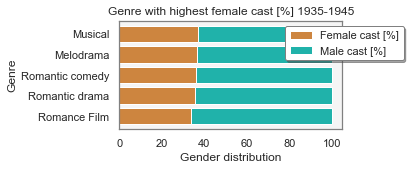

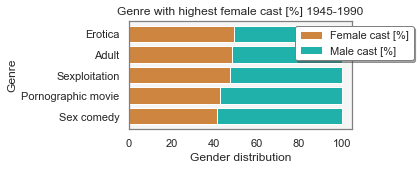

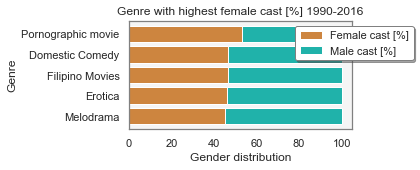

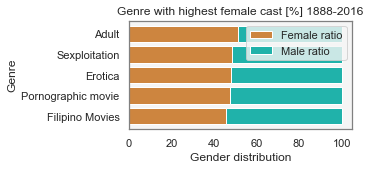

In [227]:
# Save for interactive plot
top_female_genres_interactive = []

# get top 5 genres with highest female cast ratio
for movie_genres, title in zip((movie_genres_0, movie_genres_1,movie_genres_2,movie_genres_3,movie_genres_by_year),('Genre with highest female cast [%] 1888-1935','Genre with highest female cast [%] 1935-1945','Genre with highest female cast [%] 1945-1990','Genre with highest female cast [%] 1990-2016','Genre with highest female cast [%] 1888-2016')):
    top_female_genres_tot = genderratio_domain(movie_genres, 'genres', 100, characters, 'F') # obtain df containing genre with female ratio (descending)
    top_female_genres = top_female_genres_tot.iloc[:5]
    top_female_genres['male_ratio'] = 1-top_female_genres['female_ratio']
    top_female_genres_interactive.append(top_female_genres)
    fig, ax = plt.subplots(figsize=(4, 2))
    top_female_genres_plot = top_female_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['female_ratio']*100, color="peru", label = 'Female cast [%]')
    b2 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['male_ratio']*100,  left= top_female_genres_plot['female_ratio']*100, color="lightseagreen", label = 'Male cast [%]')
    
    plt.xlabel('Female cast [%]')
    ax.set_ylabel('Genre')
    ax.set_xlabel('Gender distribution')
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    
    plt.title(title)
ax.legend([b1, b2], ["Female ratio", "Male ratio"], loc="upper right")
plt.show()

In [228]:
def female_genre_distribution(info_genre):
    lower_bound = info_genre[0]
    upper_bound = info_genre[1]
    top_female_genres = info_genre[2]
    title = f'Cast gender distribution in top 5 female genres {lower_bound} - {upper_bound}'
    
    fig, ax = plt.subplots(figsize=(10, 5))
    top_female_genres_plot = top_female_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['female_ratio'], color="peru", label = 'Female cast [%]')
    b2 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['male_ratio'],  left= top_female_genres_plot['female_ratio'], color="lightseagreen", label = 'Male cast [%]')
    
    plt.title(title)
    
    ax.set_ylabel('Genre')
    ax.set_xlabel('Gender distribution')
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    # End
    
    
    


female_genre = widgets.Dropdown(
    options=[('1888 - 1935', [1888,1935,top_female_genres_interactive[0]]), ('1935 - 1945', [1935,1945,top_female_genres_interactive[1]]), ('1945 - 1900', [1945,1900,top_female_genres_interactive[2]]),('1900 - 2016', [1990,2016, top_female_genres_interactive[3]]), ('Average of total dataset', [1888,2016,top_female_genres_interactive[4]])],
    value= [1888,2016,top_female_genres_interactive[4]],
    description='Period:',
)

widgets.interactive(female_genre_distribution, info_genre = female_genre)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1888 - 1935', [1888, 1935,          …

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
One can see that the genre with the highest female cast ratio changes in each time period. Until 1945 women appear most often in comedy, romance and musical. Those are genres that mostly are connected with less serious topics. Between 1945-1990 women play most often in movies in a sexual contex. From 1990 the two genres comedy and melodrama appear again with addition to Filipino movies. <br>
    Even in the genres where the female cast ratio is highest, the field is often still male dominant.

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The genre Filipino movies alone tells us that it was produced in the Philippines. One could hypothese that this country produces movies with an above agerage women representation. But by checking the other countries that did well in the report we can see that those countries are not listed in the genre. E.g. there is no 'Norwegian movie' genre. Therefore it is difficult to confirm is Filipinos movies are in fact better than other countries. Instead we will check the other genres that were listed with the 'Filipino movie' label and we see that some genres such as comedy, romance Film and romantic drama appear that have higher female cast percentage.  

In [229]:
check_american = np.any(movie_genres.genres == 'American movie')
print(f'There is a genre called American movie: {check_american}')
check_german = np.any(movie_genres.genres == 'German movie')
print(f'There is a genre called German movie: {check_german}')
check_icelandic = np.any(movie_genres.genres == 'New Zealand movie')
print(f'There is a genre called New Zealand movie: {check_icelandic}')
check1 = np.any(movie_genres.genres == 'Finish movie')
print(f'There is a genre called Finish movie: {check1}')
check2 = np.any(movie_genres.genres == 'Norwegian movie')
print(f'There is a genre called Norwegian movie: {check2}')
check3 = np.any(movie_genres.genres == 'Swedish movie')
print(f'There is a genre called Swedish movie: {check3}')
check4 = np.any(movie_genres.genres == 'Filipino Movies') 
print(f'There is a genre called Filipino movie: {check4}')
check5 = np.any(movie_genres.genres == 'Namibian Movies') 
print(f'There is a genre called Namibian movie: {check5}')
check6 = np.any(movie_genres.genres == 'South African Movies') 
print(f'There is a genre called Namibian movie: {check6}')
check7 = np.any(movie_genres.genres == 'Lithuanian Movies') 
print(f'There is a genre called Lithuanian movie: {check7}')
check8 = np.any(movie_genres.genres == 'Irish Movies') 
print(f'There is a genre called Irish movie: {check8}')
check9 = np.any(movie_genres.genres == 'Swiss Movies') 
print(f'There is a genre called Swiss movie: {check9}')
check10 = np.any(movie_genres.genres == 'French Movies') 
print(f'There is a genre called French movie: {check10}')

There is a genre called American movie: False
There is a genre called German movie: False
There is a genre called New Zealand movie: False
There is a genre called Finish movie: False
There is a genre called Norwegian movie: False
There is a genre called Swedish movie: False
There is a genre called Filipino movie: True
There is a genre called Namibian movie: False
There is a genre called Namibian movie: False
There is a genre called Lithuanian movie: False
There is a genre called Irish movie: False
There is a genre called Swiss movie: False
There is a genre called French movie: False


In [230]:
# Extract genre Filipino Movies
movie_Filipino = movies.copy()
movie_Filipino['genres'] = movie_Filipino['genres'].apply(lambda x: list(eval(x).values()))

# First, create a boolean mask indicating which lists contain "Italy"
mask = movie_Filipino['genres'].apply(lambda x: "Filipino Movies" in x)

# Use the boolean mask to select only the rows that contain "Italy"

Filipiono_genre = movie_Filipino[mask].explode('genres', ignore_index = True).genres.value_counts()

In [231]:
Filipiono_genre[:11], 

(Filipino Movies    346
 Drama              168
 World cinema       167
 Comedy              82
 Romance Film        72
 Romantic drama      55
 Horror              40
 Action              38
 Romantic comedy     26
 LGBT                21
 Thriller            19
 Name: genres, dtype: int64,)

In [232]:
female_filipino = Filipiono_genre['Comedy'] + Filipiono_genre['Romance Film'] + Filipiono_genre['Romantic drama'] + Filipiono_genre['Romantic comedy']
filipino_percentage = round(female_filipino/Filipiono_genre['Filipino Movies'],3)
print(f'{filipino_percentage} of the Filipino movie genre dataset is a top female genre.')

0.679 of the Filipino movie genre dataset is a top female genre.


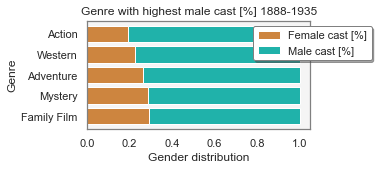

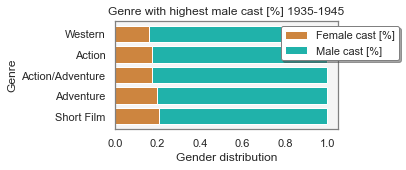

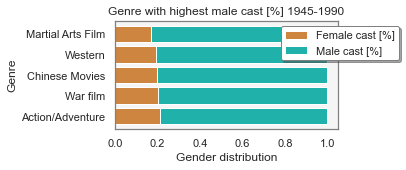

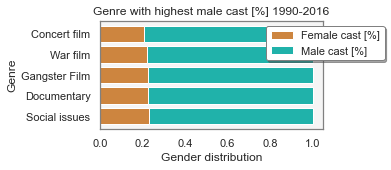

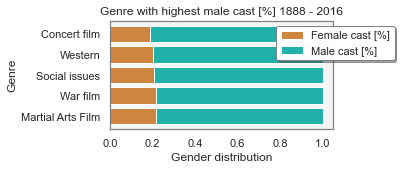

In [233]:
# Save for interactive plot
top_male_genres_interactive = []
# get top 5 genres with highest male cast ratio
for movie_genres, title in zip((movie_genres_0, movie_genres_1,movie_genres_2,movie_genres_3,movie_genres_by_year),('Genre with highest male cast [%] 1888-1935','Genre with highest male cast [%] 1935-1945','Genre with highest male cast [%] 1945-1990','Genre with highest male cast [%] 1990-2016','Genre with highest male cast [%] 1888 - 2016')):
    top_male_genres_tot = genderratio_domain(movie_genres, 'genres', 200, characters, 'M') # obtain df containing genre with highest male ratio
    top_male_genres = top_male_genres_tot.iloc[:5]
    top_male_genres['female_ratio'] = 1-top_male_genres['male_ratio']
    
    top_male_genres_interactive.append(top_male_genres)
    fig, ax = plt.subplots(figsize=(4, 2))
    top_male_genres_plot = top_male_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['female_ratio'], color="peru", label = 'Female cast [%]')
    b2 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['male_ratio'],  left= top_male_genres_plot['female_ratio'], color="lightseagreen", label = 'Male cast [%]')
    plt.title(title)
                 
    ax.set_ylabel('Genre')
    ax.set_xlabel('Gender distribution')
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    

In [234]:
def male_genre_distribution(info_genre):
    lower_bound = info_genre[0]
    upper_bound = info_genre[1]
    top_male_genres = info_genre[2]
    title = f'Cast gender distribution in top 5 male genres {lower_bound} - {upper_bound}'

    fig, ax = plt.subplots(figsize=(10, 5))
    top_male_genres_plot = top_male_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['female_ratio']*100, color="peru", label = 'Female cast [%]')
    b2 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['male_ratio']*100,  left= top_male_genres_plot['female_ratio']*100, color="lightseagreen", label = 'Male cast [%]')
    
    plt.title(title)
    
    ax.set_ylabel('Genre')
    ax.set_xlabel('Gender distribution')
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    # End
    
    
    


male_genre = widgets.Dropdown(
    options=[('1888 - 1935', [1888,1935,top_male_genres_interactive[0]]), ('1935 - 1945', [1935,1945,top_male_genres_interactive[1]]), ('1945 - 1900', [1945,1900,top_male_genres_interactive[2]]),('1900 - 2016', [1990,2016, top_male_genres_interactive[3]]), ('Average of total dataset', [1888,2016,top_male_genres_interactive[4]])],
    value= [1888,2016,top_male_genres_interactive[4]],
    description='Period:',
)

widgets.interactive(male_genre_distribution, info_genre = male_genre)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1888 - 1935', [1888, 1935,          …

In [235]:
# Extract genre Filipino Movies
movie_Chinese = movies.copy()
movie_Chinese['genres'] = movie_Chinese['genres'].apply(lambda x: list(eval(x).values()))

# First, create a boolean mask indicating which lists contain "Italy"
mask = movie_Chinese['genres'].apply(lambda x: "Chinese Movies" in x)

# Use the boolean mask to select only the rows that contain "Italy"

Chinese_genre = movie_Chinese[mask].explode('genres', ignore_index = True).genres.value_counts()

In [236]:
Chinese_genre[:10]

Chinese Movies       1525
World cinema          679
Drama                 558
Action                462
Martial Arts Film     454
Action/Adventure      400
Comedy                298
Romance Film          208
Thriller              182
Romantic drama        126
Name: genres, dtype: int64

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    In the genres with highest male cast ratio men have more roles compared to women by a high threshhold. The genres are aligned with stereotypical manly domains such as action, western and war.

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In the following we want to compute the genres with the highest male, respective female ratio for off screen roles.

In [237]:
directors_genres = directors_by_year.copy()
directors_genres['genres'] = directors_genres['genres'].apply(lambda x: list(eval(x).values()))
directors_genres = directors_genres.explode('genres', ignore_index = True)
directors_genres_copy = directors_genres.copy()
directors_genres_copy = directors_genres_copy[(directors_genres_copy['genres']!= 'NaN') |(directors_genres_copy['genres']!= np.nan) ]

In [238]:
directors_genres_by_year = directors_genres_copy[~pd.isna(directors_genres_copy['release_date'])] # drop NaN release date
directors_genres_by_year['release_date'] = pd.to_datetime(directors_genres_by_year['release_date']) # transform to datetime format
directors_genres_by_year['release_year'] = directors_genres_by_year['release_date'].dt.to_period('Y') # create year column
directors_genres_by_year['release_year'] = directors_genres_by_year['release_year'].astype(str)
directors_genres_by_year['release_year'] = directors_genres_by_year['release_year'].astype(int)

directors_genres_0 = directors_genres_by_year[directors_genres_by_year['release_year']<=1935]
directors_genres_1 = directors_genres_by_year[(directors_genres_by_year['release_year']>=1935) & (directors_genres_by_year['release_year']<=1945)]
directors_genres_2 = directors_genres_by_year[(directors_genres_by_year['release_year']>=1945) & (directors_genres_by_year['release_year']<=1990)]
directors_genres_3 = directors_genres_by_year[(directors_genres_by_year['release_year']>=1990)]

In [239]:
def gender_ratio_offscreen(df, domain, gender, threshold):
    '''
    gender = 'M'
    domain = 'genres'
    df = directors_genres_0'''
    gender_genres = df[['gender', domain]].groupby(domain).agg('sum')
    gender_genres = gender_genres.reset_index(level=0)
    if gender == 'F':
        gender_ratio = "female_ratio"
    else:
        gender_ratio = "male_ratio"  
    # checking for general genre can lead to loss of some data
    if len(gender_genres)>threshold:
        gender_genres[gender_ratio] = gender_genres['gender'].apply(lambda x: get_gender_ratio(x,gender))
        gender_genres = gender_genres.drop(columns=['gender'])
        gender_genres = gender_genres.sort_values(by=gender_ratio, ascending=False)
    return gender_genres

In [240]:
top_male_genres_tot_check = gender_ratio_offscreen(directors_genres_by_year, 'genres', 'M',100)

In [241]:
men_reigned = len(top_male_genres_tot_check[top_male_genres_tot_check.male_ratio == 1].genres.value_counts())
total_genre = len(top_male_genres_tot_check.genres.value_counts())
print(f"{round(men_reigned,3)} from {round(total_genre, 3)} genres solely have male directors")

29 from 357 genres solely have male directors


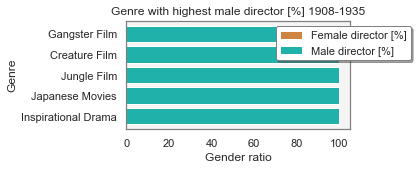

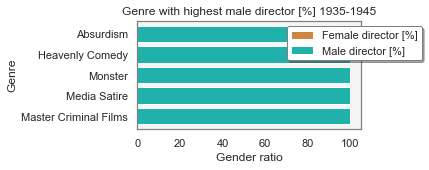

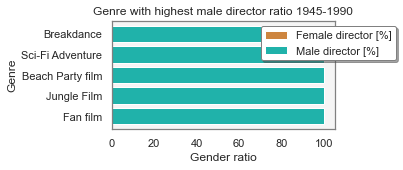

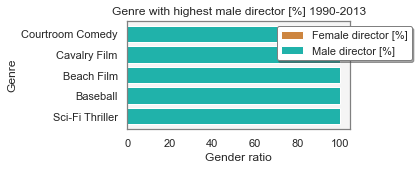

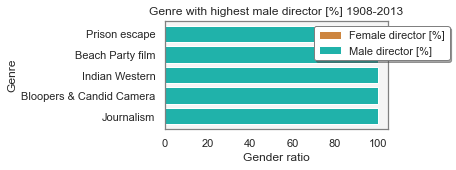

In [242]:
# Save data for interactive plot
director_male_genres_interactive = []

# get top 5 genres with highest male director ratio
for director_genres, title in zip((directors_genres_0, directors_genres_1,directors_genres_2,directors_genres_3,directors_genres_by_year),('Genre with highest male director [%] 1908-1935','Genre with highest male director [%] 1935-1945','Genre with highest male director ratio 1945-1990','Genre with highest male director [%] 1990-2013','Genre with highest male director [%] 1908-2013')):
    top_male_genres_tot = gender_ratio_offscreen(director_genres, 'genres', 'M',100) # obtain df containing genre with highest male ratio
    
    men_reigned = len(top_male_genres_tot[top_male_genres_tot.male_ratio == 1].genres.value_counts())
    if men_reigned > 5:#Find all genres with 100% male director and sort according to popularity of genre
        top_male_genres = top_male_genres_tot.iloc[:men_reigned]
        df_sort = top_male_genres_tot[(top_male_genres_tot['male_ratio'] == 1)] 
        is_in_genre = df_sort['genres'].apply(lambda x: x in movie_genres['genres'].unique())
        df_sort = df_sort[is_in_genre]
        top_male_genres = sort_to_genre(df_sort, movie_genres)[:5]
        top_male_genres = top_male_genres_tot.iloc[:5]
    
    top_male_genres['female_ratio'] = 1-top_male_genres['male_ratio']    
    director_male_genres_interactive.append(top_male_genres)
    fig, ax = plt.subplots(figsize=(4, 2))
    top_male_genres_plot = top_male_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['female_ratio']*100, color="peru", label = 'Female director [%]')
    b2 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['male_ratio']*100,  left= top_male_genres_plot['female_ratio']*100, color="lightseagreen", label = 'Male director [%]')
    plt.xlabel('Gender ratio')
    plt.ylabel('Genre')
    plt.title(title)
    
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    #ax.legend([b1, b2], ["Female ratio", "Male ratio"], loc="upper right")
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    plt.show()

In [243]:
def male_director_genre(info_director):
    lower_bound = info_director[0]
    upper_bound = info_director[1]
    top_male_genres = info_director[2]
    title = f'Director gender distribution in top 5 male genres {lower_bound} - {upper_bound}' 
    
    fig, ax = plt.subplots(figsize=(10, 5))
    top_male_genres_plot = top_male_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['female_ratio']*100, color="peru", label = 'Female director [%]')
    b2 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['male_ratio']*100,  left= top_male_genres_plot['female_ratio'], color="lightseagreen", label = 'Male director [%]')
    plt.title(title)
    ax.set_ylabel('Genre')
    ax.set_xlabel('Gender distribution')
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)
    # End
    
    
male_director = widgets.Dropdown(
    options=[('1908 - 1935', [1908,1935,director_male_genres_interactive[0]]), ('1935 - 1945', [1935,1945,director_male_genres_interactive[1]]), ('1945 - 1900', [1945,1900,director_male_genres_interactive[2]]),('1900 - 2013', [1990,2013, director_male_genres_interactive[3]]), ('Average of total dataset', [1903,2013,director_male_genres_interactive[4]])],
    value= [1903,2013,director_male_genres_interactive[4]],
    description='Period:',
)

widgets.interactive(male_director_genre, info_director = male_director)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1908, 1935,          …

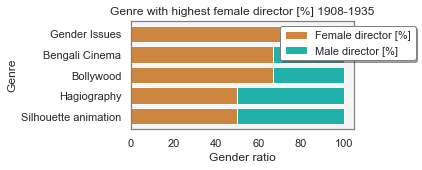

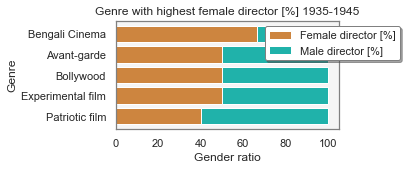

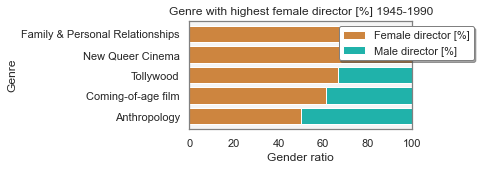

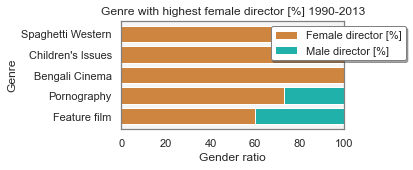

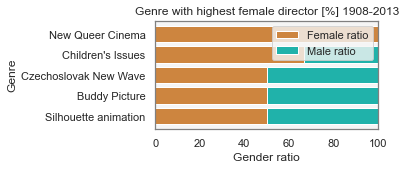

In [244]:
# Save data for interactive plot
top_female_genres_director_interactive = []

# get top 5 genres with highest male director ratio
for director_genres, title in zip((directors_genres_0, directors_genres_1,directors_genres_2,directors_genres_3,directors_genres_by_year),('Genre with highest female director [%] 1908-1935','Genre with highest female director [%] 1935-1945','Genre with highest female director [%] 1945-1990','Genre with highest female director [%] 1990-2013','Genre with highest female director [%] 1908-2013')):
    top_female_genres_tot = gender_ratio_offscreen(director_genres, 'genres', 'F',100) # obtain df containing genre with highest male ratio
    top_female_genres = top_female_genres_tot.iloc[:5]
    top_female_genres['male_ratio'] = 1-top_female_genres['female_ratio']
    top_female_genres_director_interactive.append(top_female_genres)
    
    fig, ax = plt.subplots(figsize=(4, 2))
    top_female_genres_plot = top_female_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['female_ratio']*100, color="peru", label = 'Female director [%]')
    b2 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['male_ratio']*100,  left= top_female_genres_plot['female_ratio']*100, color="lightseagreen", label = 'Male director [%]')
    plt.xlabel('Gender ratio')
    plt.ylabel('Genre')
    plt.title(title)
    
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    
ax.legend([b1, b2], ["Female ratio", "Male ratio"], loc="upper right")
plt.show()

In [245]:
def female_director_genre(info_director):
    lower_bound = info_director[0]
    upper_bound = info_director[1]
    top_female_genres = info_director[2]
    title = f'Director gender distribution in top 5 female genres {lower_bound} - {upper_bound}'
    fig, ax = plt.subplots(figsize=(10, 5))
    
    top_female_genres_plot = top_female_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['female_ratio']*100, color="peru", label = 'Female director [%]')
    b2 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['male_ratio']*100,  left= top_female_genres_plot['female_ratio']*100, color="lightseagreen", label = 'Male director [%]')
    plt.xlabel('Gender ratio')
    plt.ylabel('Genre')
    plt.title(title)
    
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    # End
    
    
female_director = widgets.Dropdown(
    options=[('1908 - 1935', [1908,1935,top_female_genres_director_interactive[0]]), ('1935 - 1945', [1935,1945,top_female_genres_director_interactive[1]]), ('1945 - 1900', [1945,1900,top_female_genres_director_interactive[2]]),('1900 - 2013', [1990,2013, top_female_genres_director_interactive[3]]), ('Average of total dataset', [1903,2013,top_female_genres_director_interactive[4]])],
    value= [1903,2013,top_female_genres_director_interactive[4]],
    description='Period:',
)

widgets.interactive(female_director_genre, info_director = female_director)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1908, 1935,          …

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Same for writer.

In [246]:
writers_genres = writers_by_year.copy()
writers_genres['genres'] = writers_genres['genres'].apply(lambda x: list(eval(x).values()))
writers_genres = writers_genres.explode('genres', ignore_index = True)
writers_genres_copy = writers_genres.copy()
writers_genres_copy = writers_genres_copy[(writers_genres_copy['genres']!= 'NaN') |(writers_genres_copy['genres']!= np.nan) ]

In [247]:
writers_genres_by_year = writers_genres_copy[~pd.isna(writers_genres_copy['release_date'])] # drop NaN release date
writers_genres_by_year['release_date'] = pd.to_datetime(writers_genres_by_year['release_date']) # transform to datetime format
writers_genres_by_year['release_year'] = writers_genres_by_year['release_date'].dt.to_period('Y') # create year column
writers_genres_by_year['release_year'] = writers_genres_by_year['release_year'].astype(str)
writers_genres_by_year['release_year'] = writers_genres_by_year['release_year'].astype(int)

writers_genres_0 = writers_genres_by_year[writers_genres_by_year['release_year']<=1935]
writers_genres_1 = writers_genres_by_year[(writers_genres_by_year['release_year']>=1935) & (writers_genres_by_year['release_year']<=1945)]
writers_genres_2 = writers_genres_by_year[(writers_genres_by_year['release_year']>=1945) & (writers_genres_by_year['release_year']<=1990)]
writers_genres_3 = writers_genres_by_year[(writers_genres_by_year['release_year']>=1990)]

In [249]:
men_reigned = len(top_male_genres_tot[top_male_genres_tot.male_ratio == 1].genres.value_counts())
if men_reigned > 5:#Find all genres with 100% male director and sort according to popularity of genre
    top_male_genres = top_male_genres_tot.iloc[:men_reigned]

In [250]:
top_male_genres_tot_check = gender_ratio_offscreen(writers_genres_by_year, 'genres', 'M',100)
men_reigned = len(top_male_genres_tot_check[top_male_genres_tot_check.male_ratio == 1].genres.value_counts())
total_genre = len(top_male_genres_tot_check.genres.value_counts())
print(f"{round(men_reigned,3)} from {round(total_genre, 3)} genres solely have male writer")

16 from 358 genres solely have male writer


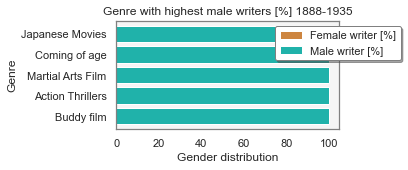

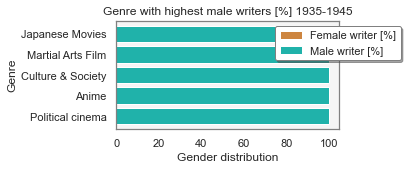

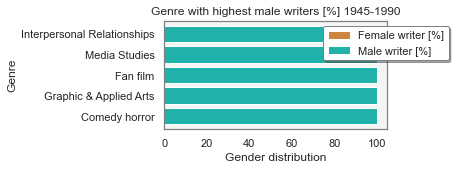

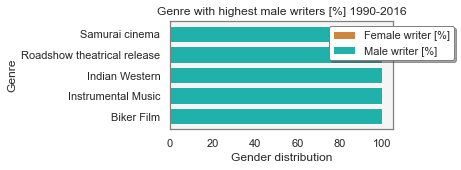

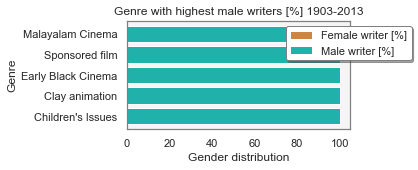

In [251]:
# Save for interactive plot
writer_male_genres_interactive = []

# get top 5 genres with highest male writers ratio
for writers_genres, title in zip((writers_genres_0, writers_genres_1,writers_genres_2,writers_genres_3,writers_genres_by_year),('Genre with highest male writers [%] 1888-1935','Genre with highest male writers [%] 1935-1945','Genre with highest male writers [%] 1945-1990','Genre with highest male writers [%] 1990-2016','Genre with highest male writers [%] 1903-2013')):
    top_male_genres_tot = gender_ratio_offscreen(writers_genres, 'genres', 'M',100) # obtain df containing genre with highest male ratio
    men_reigned = len(top_male_genres_tot[top_male_genres_tot.male_ratio == 1].genres.value_counts())
    if men_reigned > 5:#Find all genres with 100% male writer and sort according to popularity of genre
        top_male_genres = top_male_genres_tot.iloc[:men_reigned]
        df_sort = top_male_genres_tot[(top_male_genres_tot['male_ratio'] == 1)] 
        is_in_genre = df_sort['genres'].apply(lambda x: x in movie_genres['genres'].unique())
        df_sort = df_sort[is_in_genre]
        top_male_genres = sort_to_genre(df_sort, movie_genres)[:5]
    top_male_genres['female_ratio'] = 1-top_male_genres['male_ratio']   
    
    writer_male_genres_interactive.append(top_male_genres)
    fig, ax = plt.subplots(figsize=(4, 2))
    top_male_genres_plot = top_male_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['female_ratio']*100, color="peru", label = 'Female writer [%]')
    b2 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['male_ratio']*100,  left= top_male_genres_plot['female_ratio']*100, color="lightseagreen", label = 'Male writer [%]')
    plt.xlabel('Gender distribution')
    plt.ylabel('Genre')
    plt.title(title)
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)


In [252]:
def male_writer_genre(info_writer):
    lower_bound = info_writer[0]
    upper_bound = info_writer[1]
    top_male_genres = info_writer[2]
    title = f'Director gender distribution in top 5 male genres {lower_bound} - {upper_bound}'
    fig, ax = plt.subplots(figsize=(10, 5))
    
    top_male_genres_plot = top_male_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['female_ratio'], color="peru", label = 'Female writer [%]')
    b2 = ax.barh(top_male_genres_plot['genres'], top_male_genres_plot['male_ratio'],  left= top_male_genres_plot['female_ratio'], color="lightseagreen", label = 'Male writer [%]')
    plt.xlabel('Gender ratio')
    plt.ylabel('Genre')
    plt.title(title)
    
    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    # End
    
    
male_writer = widgets.Dropdown(
    options=[('1908 - 1935', [1908,1935,writer_male_genres_interactive[0]]), ('1935 - 1945', [1935,1945,writer_male_genres_interactive[1]]), ('1945 - 1900', [1945,1900,writer_male_genres_interactive[2]]),('1900 - 2013', [1990,2013, writer_male_genres_interactive[3]]), ('Average of total dataset', [1903,2013,writer_male_genres_interactive[4]])],
    value= [1903,2013,writer_male_genres_interactive[4]],
    description='Period:',
)

widgets.interactive(male_writer_genre, info_writer = male_writer)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1908, 1935,          …

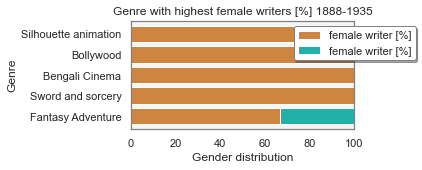

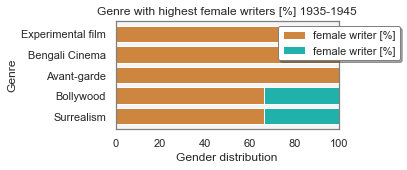

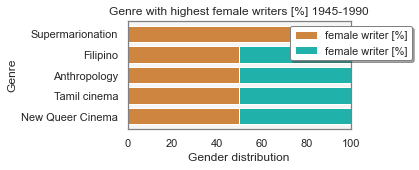

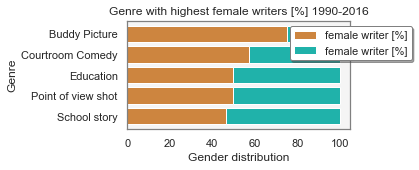

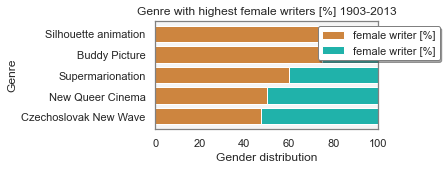

In [253]:
# Save for interactive plot
writer_female_genres_interactive = []

# get top 5 genres with highest female writers ratio
for writers_genres, title in zip((writers_genres_0, writers_genres_1,writers_genres_2,writers_genres_3,writers_genres_by_year),('Genre with highest female writers [%] 1888-1935','Genre with highest female writers [%] 1935-1945','Genre with highest female writers [%] 1945-1990','Genre with highest female writers [%] 1990-2016','Genre with highest female writers [%] 1903-2013')):
    top_female_genres_tot = gender_ratio_offscreen(writers_genres, 'genres', 'F',100) # obtain df containing genre with highest female ratio
    top_female_genres = top_female_genres_tot.iloc[:5]
    
    if top_female_genres['female_ratio'].sum() == 5: # We need to sort according to popularity of genre
        df_sort = top_female_genres_tot[(top_female_genres_tot['female_ratio'] == 1)] 
        is_in_genre = df_sort['genres'].apply(lambda x: x in movie_genres['genres'].unique())
        df_sort = df_sort[is_in_genre]
        top_female_genres = sort_to_genre(df_sort, movie_genres)[:5]
    top_female_genres['male_ratio'] = 1-top_female_genres['female_ratio']   
    
    writer_female_genres_interactive.append(top_female_genres)
    fig, ax = plt.subplots(figsize=(4, 2))
    top_female_genres_plot = top_female_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['female_ratio']*100, color="peru", label = 'female writer [%]')
    b2 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['male_ratio']*100,  left= top_female_genres_plot['female_ratio']*100, color="lightseagreen", label = 'female writer [%]')
    plt.xlabel('Gender distribution')
    plt.ylabel('Genre')
    plt.title(title)
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)


In [254]:
def female_writer_genre(info_writer):
    lower_bound = info_writer[0]
    upper_bound = info_writer[1]
    top_female_genres = info_writer[2]
    title = f'Director gender distribution in top 5 female genres {lower_bound} - {upper_bound}'
    fig, ax = plt.subplots(figsize=(10, 5))
    
    top_female_genres_plot = top_female_genres[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['female_ratio']*100, color="peru", label = 'female writer [%]')
    b2 = ax.barh(top_female_genres_plot['genres'], top_female_genres_plot['male_ratio']*100,  left= top_female_genres_plot['female_ratio']*100, color="lightseagreen", label = 'female writer [%]')
    plt.xlabel('Gender ratio')
    plt.ylabel('Genre')
    plt.title(title)
    
    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    # End
    
    
female_writer = widgets.Dropdown(
    options=[('1908 - 1935', [1908,1935,writer_female_genres_interactive[0]]), ('1935 - 1945', [1935,1945,writer_female_genres_interactive[1]]), ('1945 - 1900', [1945,1900,writer_female_genres_interactive[2]]),('1900 - 2013', [1990,2013, writer_female_genres_interactive[3]]), ('Average of total dataset', [1903,2013,writer_female_genres_interactive[4]])],
    value= [1903,2013,writer_female_genres_interactive[4]],
    description='Period:',
)

widgets.interactive(female_writer_genre, info_writer = female_writer)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1908, 1935,          …

#### 2.3.1 Countries

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Another task is to show the gender gap across the world. For that we show the countries that produces movies with the highes female or male ratio. In this case all countries are considered that have produced more than 100 movies.

In [255]:
movie_countries_copy = movie_countries.copy()
movie_countries_by_year = movie_countries_copy[~pd.isna(movie_countries_copy['release_date'])] # drop NaN release date
movie_countries_by_year['release_date'] = pd.to_datetime(movie_countries_by_year['release_date']) # transform to datetime format
movie_countries_by_year['release_year'] = movie_countries_by_year['release_date'].dt.to_period('Y') # create year column
movie_countries_by_year['release_year'] = movie_countries_by_year['release_year'].astype(str)
movie_countries_by_year['release_year'] = movie_countries_by_year['release_year'].astype(int)

movie_countries_0 = movie_countries_by_year[movie_countries_by_year['release_year']<=1935]
movie_countries_1 = movie_countries_by_year[(movie_countries_by_year['release_year']>=1935) & (movie_countries_by_year['release_year']<=1945)]
movie_countries_2 = movie_countries_by_year[(movie_countries_by_year['release_year']>=1945) & (movie_countries_by_year['release_year']<=1990)]
movie_countries_3 = movie_countries_by_year[(movie_countries_by_year['release_year']>=1990)]

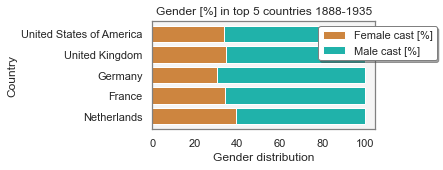

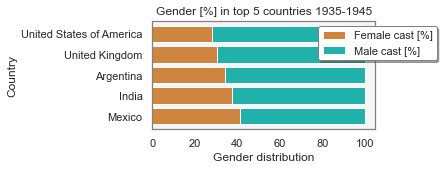

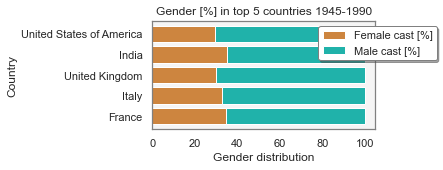

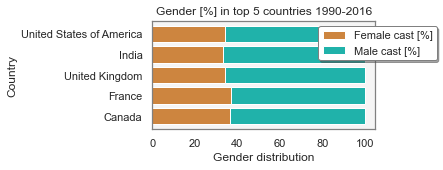

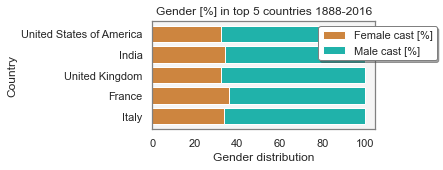

In [256]:
# Save for interactive plot
countries_gender_interactive = []
# get top 5 countries of all movie
for movie_countries, title in zip((movie_countries_0, movie_countries_1,movie_countries_2,movie_countries_3,movie_countries_by_year),('Gender [%] in top 5 countries 1888-1935','Gender [%] in top 5 countries 1935-1945','Gender [%] in top 5 countries 1945-1990','Gender [%] in top 5 countries 1990-2016','Gender [%] in top 5 countries 1888-2016')):
    top5_countries = movie_countries['countries'].value_counts()[:5].to_frame().reset_index().rename(columns={"index": "countries", "countries": "counts"})
    
    character_countries = pd.merge(left = characters, right = movie_countries, left_on = 'wiki_movie_id', right_on = 'wiki_movie_id', how = 'inner')
    countries_gender = character_countries[character_countries.countries.isin(top5_countries.countries.to_list())][['actor_gender', 'countries']].groupby('countries').agg('sum')
    countries_gender['female_ratio'] = countries_gender['actor_gender'].apply(lambda x: get_gender_ratio(x, "F"))
    countries_gender = countries_gender.drop(columns=['actor_gender']).reset_index()
    countries_gender = pd.merge(left = countries_gender, right = top5_countries, on='countries', how='left')
    countries_gender = countries_gender.sort_values(by='counts', ascending=False).reset_index()
    countries_gender['male_ratio'] = 1-countries_gender['female_ratio']
    
    countries_gender_interactive.append(countries_gender)
    fig, ax = plt.subplots(figsize=(4, 2))
    countries_gender_plot = countries_gender[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(countries_gender_plot['countries'], countries_gender_plot['female_ratio']*100, color="peru", label = 'Female cast [%]')
    b2 = ax.barh(countries_gender_plot['countries'], countries_gender_plot['male_ratio']*100,  left= countries_gender_plot['female_ratio']*100 , color="lightseagreen", label = 'Male cast [%]')
    plt.xlabel('Gender distribution')
    plt.ylabel('Country')
    plt.title(title)
    ax.grid(visible=False)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)


In [257]:
def country_distribution(info_country):
    lower_bound = info_country[0]
    upper_bound = info_country[1]
    countries_gender = info_country[2]
    title = f'Cast gender distribution in top 5 countries {lower_bound} - {upper_bound}'
    fig, ax = plt.subplots(figsize=(10, 5))
    
    countries_gender_plot = countries_gender[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(countries_gender_plot['countries'], countries_gender_plot['female_ratio']*100, color="peru", label = 'Female cast [%]')
    b2 = ax.barh(countries_gender_plot['countries'], countries_gender_plot['male_ratio']*100,  left= countries_gender_plot['female_ratio']*100 , color="lightseagreen", label = 'Male cast [%]')
    plt.xlabel('Gender distribution')
    plt.ylabel('Country')
    plt.title(title)
    
    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    # End
    
    
top_country = widgets.Dropdown(
    options=[('1908 - 1935', [1888,1935,countries_gender_interactive[0]]), ('1935 - 1945', [1935,1945,countries_gender_interactive[1]]), ('1945 - 1900', [1945,1900,countries_gender_interactive[2]]),('1900 - 2013', [1990,2016, countries_gender_interactive[3]]), ('Average of total dataset', [1888,2016,countries_gender_interactive[4]])],
    value= [1888,2016,countries_gender_interactive[4]],
    description='Period:',
)

widgets.interactive(country_distribution, info_country = top_country)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1888, 1935,    index …

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We check if some countries are in the dataset that stopped existing in the 20th century. <br>
    Based on: https://en.wikipedia.org/wiki/List_of_former_sovereign_states <br>
    The countries that are in our movie dataset Czechoslovakia (1992), Yugoslavia (1992), Burma (1948)

In [258]:
old_countries = ['Republic of the Rif', 'Alawi dynasty', 'Sultanate of Darfur', 'Sultanate of Egypt','Tripolitanian Republic', 'United Arab Republic',
                'Kingdom of Egypt', 'Emirate of Cyrenaica','Kingdom of Libya', 'Republic of Egypt', 'Republic of the Sudan', 'United Arab Republic',
                'Democratic Republic of the Sudan', 'Libyan Arab Republic', 'State of the Comoros', 'Ali Soilih Regime', 'Federal and Islamic Republic of the Comoros',
                'State of Anjouan', 'Malagasy Republic', 'Democratic Republic of Madagascar', 'Third Republic of Madagascar', 
                'Central African Empire', 'Aussa Sultanate', 'Habr Yunis Sultanate', 'Sultanate of Hobyo', 'Neutral Moresnet', 
                'Tibet', 'United Arab Republic', 'Sikkim', 'Ceylon', 'Czechoslovakia', 'East Germany', 'Yugoslavia', 'Burma', 
                'Corsica','Newfoundland', 'Basutoland', 'Persia','Siam']

In [259]:
print('Following countries are in the dataset and stopped existing in the 20th century:')
for country in old_countries:
    if np.any(movie_countries_by_year['countries'] == country):
        print(country)

Following countries are in the dataset and stopped existing in the 20th century:
Czechoslovakia
Yugoslavia
Burma


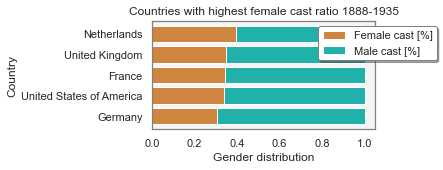

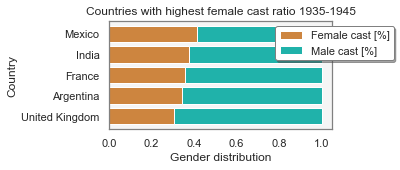

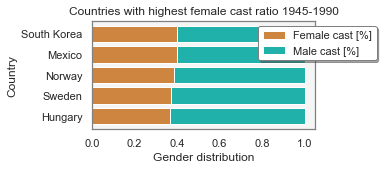

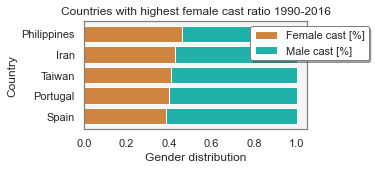

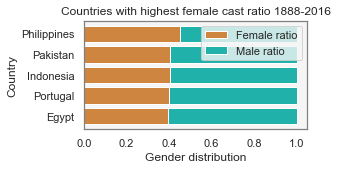

In [260]:
# save for interactive plot
top_female_countries_interactive = []
# get top 5 countries with highest fefemale cast ratio
for movie_countries, title in zip((movie_countries_0, movie_countries_1,movie_countries_2,movie_countries_3,movie_countries_by_year),('Countries with highest female cast ratio 1888-1935','Countries with highest female cast ratio 1935-1945','Countries with highest female cast ratio 1945-1990','Countries with highest female cast ratio 1990-2016','Countries with highest female cast ratio 1888-2016')):
    top_female_countries_tot = genderratio_domain(movie_countries, 'countries', 100, characters, 'F') # obtain df containing Countries with highest female ratio
    top_female_countries = top_female_countries_tot.iloc[:5]
    top_female_countries['male_ratio'] = 1-top_female_countries['female_ratio']
    top_female_countries_interactive.append(top_female_countries)
    
    fig, ax = plt.subplots(figsize=(4, 2))
    top_female_countries_plot = top_female_countries[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_female_countries_plot['countries'], top_female_countries_plot['female_ratio'], color="peru", label = 'Female cast [%]')
    b2 = ax.barh(top_female_countries_plot['countries'], top_female_countries_plot['male_ratio'],  left= top_female_countries_plot['female_ratio'], color="lightseagreen", label = 'Male cast [%]')
    plt.xlabel('Gender distribution')
    plt.ylabel('Country')
    plt.title(title)
    fig.patch.set_facecolor('white')
    ax.grid(visible=False)
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')

    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    
    
ax.legend([b1, b2], ["Female ratio", "Male ratio"], loc="upper right")
plt.show()

In [261]:
def country_female(info_country):
    lower_bound = info_country[0]
    upper_bound = info_country[1]
    countries_gender = info_country[2]
    title = f'Cast gender distribution in top 5 countries {lower_bound} - {upper_bound}'
    fig, ax = plt.subplots(figsize=(10, 5))
    
    countries_gender_plot = countries_gender[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(countries_gender_plot['countries'], countries_gender_plot['female_ratio'], color="peru", label = 'Female cast [%]')
    b2 = ax.barh(countries_gender_plot['countries'], countries_gender_plot['male_ratio'],  left= countries_gender_plot['female_ratio'] , color="lightseagreen", label = 'Male cast [%]')
    plt.xlabel('Gender distribution')
    plt.ylabel('Country')
    plt.title(title)
    
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    ax.grid(visible=True, color='silver')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    # End
    
    
f_country = widgets.Dropdown(
    options=[('1908 - 1935', [1888,1935,top_female_countries_interactive[0]]), ('1935 - 1945', [1935,1945,top_female_countries_interactive[1]]), ('1945 - 1900', [1945,1900,top_female_countries_interactive[2]]),('1900 - 2013', [1990,2016, top_female_countries_interactive[3]]), ('Average of total dataset', [1888,2016,top_female_countries_interactive[4]])],
    value= [1888,2016,top_female_countries_interactive[4]],
    description='Period:',
)

widgets.interactive(country_female, info_country = f_country)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1888, 1935,          …

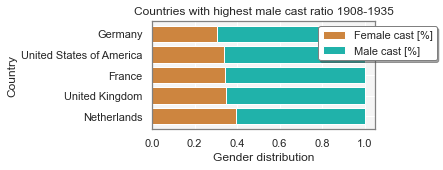

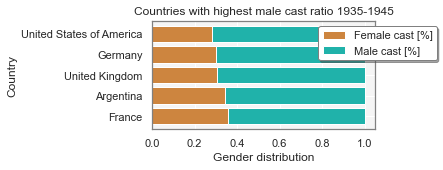

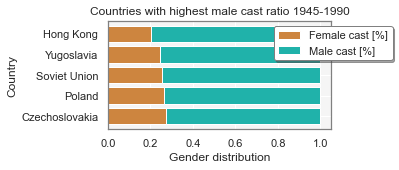

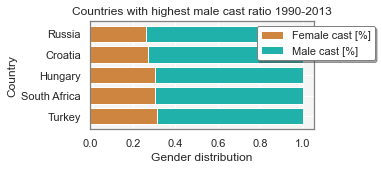

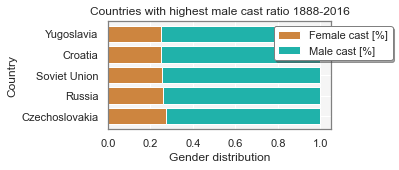

In [262]:
# Save for interactive plot
top_male_countries_interactive = []

# get top 5 countries with highest male cast ratio
for movie_countries, title in zip((movie_countries_0, movie_countries_1,movie_countries_2,movie_countries_3,movie_countries_by_year),('Countries with highest male cast ratio 1908-1935','Countries with highest male cast ratio 1935-1945','Countries with highest male cast ratio 1945-1990','Countries with highest male cast ratio 1990-2013','Countries with highest male cast ratio 1888-2016')):
    top_male_countries = genderratio_domain(movie_countries, 'countries', 100, characters, 'M').iloc[:5] # obtain df containing Countries with highest male ratio
    top_male_countries['female_ratio'] = 1-top_male_countries['male_ratio']
    top_male_countries_interactive.append(top_male_countries)
    
    fig, ax = plt.subplots(figsize=(4, 2))
    top_male_countries_plot = top_male_countries[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(top_male_countries_plot['countries'], top_male_countries_plot['female_ratio'], color="peru", label = 'Female cast [%]')
    b2 = ax.barh(top_male_countries_plot['countries'], top_male_countries_plot['male_ratio'],  left= top_male_countries_plot['female_ratio'], color="lightseagreen", label = 'Male cast [%]')
    plt.xlabel('Gender distribution')
    plt.ylabel('Country')
    plt.title(title)
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)



In [263]:
def country_male(info_country):
    lower_bound = info_country[0]
    upper_bound = info_country[1]
    countries_gender = info_country[2]
    title = f'Cast gender distribution in top 5 countries {lower_bound} - {upper_bound}'
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.patch.set_facecolor('white')
    countries_gender_plot = countries_gender[::-1] # Reverse order because horzontal boxplot plots boxes in reverse order
    b1 = ax.barh(countries_gender_plot['countries'], countries_gender_plot['female_ratio'], color="peru", label = 'Female cast [%]')
    b2 = ax.barh(countries_gender_plot['countries'], countries_gender_plot['male_ratio'],  left= countries_gender_plot['female_ratio'] , color="lightseagreen", label = 'Male cast [%]')
    plt.xlabel('Gender distribution')
    plt.ylabel('Country')
    plt.title(title)
    
    ax.grid(visible=True, color='silver')
    fig.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1), facecolor='white', framealpha=1, edgecolor='0.5',shadow=True)

    # End
    
    
m_country = widgets.Dropdown(
    options=[('1908 - 1935', [1888,1935,top_male_countries_interactive[0]]), ('1935 - 1945', [1935,1945,top_male_countries_interactive[1]]), ('1945 - 1900', [1945,1900,top_male_countries_interactive[2]]),('1900 - 2013', [1990,2016, top_male_countries_interactive[3]]), ('Average of total dataset', [1888,2016,top_male_countries_interactive[4]])],
    value= [1888,2016,top_male_countries_interactive[4]],
    description='Period:',
)

widgets.interactive(country_male, info_country = m_country)

interactive(children=(Dropdown(description='Period:', index=4, options=(('1908 - 1935', [1888, 1935,          …

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In order to visualize the gender ratio the gender ratio is shown as a heatmap in the worldmap. We found out that the latest dataset change was in 1992. Therefore the time period mapped is from 1992 on. Many countries only produced a few movies. In the tasks above we set a threshhold regarding the minimum number of movies that have to be prouced within a country. For this task we set this threshhold to 1. <br>
Since Antarctica is not within the dataset but occupies a large space it was dropped from the map.

In [264]:
import geopandas as gpd
shapefile = 'data/countries_110m/ne_110m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']

In [265]:
# Check if Antarctica is within the dataset
print('There is a datapoint with feature country = Antarctica:')
np.any([movie_countries_3['countries'] == 'Antarctica'])

There is a datapoint with feature country = Antarctica:


False

In [266]:
#Drop row corresponding to 'Antarctica'
gdf = gdf.loc[~(gdf['country'] == 'Antarctica')]#Drop row corresponding to 'Antarctica'

In [267]:
# Extract data where no more change in countries has happened and calculate female ratio
movie_countries_constant = movie_countries_by_year[movie_countries_by_year['release_year']>1992]
ratio_country = genderratio_domain(movie_countries_constant, 'countries', 50, characters, 'F') # obtain df containing Countries with female ratio (descending)
ratio_country['male_ratio'] = 1-ratio_country['female_ratio']


In [268]:
#Merge dataframes gdf and df_2016.
merged = gdf.merge(ratio_country, left_on = 'country', right_on = 'countries') # left merge to perserve all countries

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))
plt.xticks(rotation=90)
merged.plot(column="female_ratio", cmap = "viridis", linewidth=0.4, ax=ax, edgecolor=".4",vmin=0, vmax= 1)
bar_info = plt.cm.ScalarMappable(cmap="viridis")
bar_info._A = []
cbar = fig.colorbar(bar_info)
ax.axis("off")
plt.title('Female cast ratio 1993-2016')

Plot interactive plot in Jekyll: http://dmnfarrell.github.io/plotting/embed-bokeh-plots-jekyll

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
In order to show countries without gender information we have to do a left side join. The goal is to plot an interactive map where time period can be chosen.

In [270]:
#Merge dataframes gdf and df_2016.
merged = gdf.merge(ratio_country, left_on = 'country', right_on = 'countries', how = 'left') # left merge to perserve all countries

In [272]:
#Replace NaN values to string 'No data' because NaN is not a valid JSON object
#merged.fillna('No data', inplace = True)

# Change to GeoJSON for interactive Bokeh visualization

#Read data to json.
merged_json = json.loads(merged.to_json())
#Convert to String like object.
json_data = json.dumps(merged_json)

In [340]:
# Input data with features for plotting.
geosource = GeoJSONDataSource(geojson = json_data)

# Visualization parameter
palette = brewer['BrBG'][8]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 1,nan_color = '#d9d9d9') # Set high to 1 because highest female ratio possible = 1
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')

#Add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('Female ratio', '@female_ratio'), ('Male ratio', '@male_ratio')])

# Create figure object.
p = figure(title = 'Gender ratio between 1993-2016', height  = 600 , width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.patches(xs='xs',ys='ys', source = geosource, fill_color = {'field' :'female_ratio', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

# figure layout.
p.add_layout(color_bar, 'below')

output_notebook()
output_file("pictures/gender_ratio_map.html")
show(p)

Loading BokehJS ...

## Change over time

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
For the next task the change regarding time should be shown. There are too many genres to show in one plot and the most popular genres varies with time. Therefore the time series of the latest most popular genres is shown <br>
    Per year we only take the genre into consideration if there are at least 50 movies.

In [284]:
# Find top 20 genres & create genre_ts dataframe for those genres
top20_genres = np.unique(pd.concat(top_female_genres_interactive).genres.values)
#movie_genres['genres'].value_counts()[:20].to_frame().reset_index().rename(columns={"index": "genres", "genres": "counts"})
genre_time_series = pd.DataFrame(index=top20_genres)
# dataframe only containing top 5 genres
genre_ts = movie_genres[movie_genres['genres'].isin(top20_genres)]

# Calculate the years in which the top 20 genres have values
years = movie_genres['release_year'].drop_duplicates( keep='last')
years = years.astype(str).sort_values(ascending=[True])

for iter_year in years.values:
    subdata = genre_ts[genre_ts['release_year'] == int(iter_year)]
    min_nmovies = 100
    if len(subdata)>min_nmovies:
        g_ratio = genderratio_domain(subdata, 'genres', min_nmovies, characters, 'F')
        if len(g_ratio) >0:
            genre_ratio_ts = g_ratio.set_index('genres') # obtain df containing Countries with highest female ratio
            genre_ratio_ts = genre_ratio_ts.reindex(top20_genres)

            # Append ratio to df
            add_data = genre_ratio_ts.rename(columns={'female_ratio': iter_year})
            genre_time_series = pd.concat([genre_time_series, add_data], axis=1)
genre_time_series = genre_time_series.T

In [285]:
# TS of top female genres
female_genre = np.unique(pd.concat(top_female_genres_interactive).genres.values)
f_genre_time_series = pd.DataFrame(index= female_genre)
f_genre_ts = movie_genres[movie_genres['genres'].isin(female_genre)]

# Calculate the years in which the top genres have values
years = movie_genres['release_year'].drop_duplicates( keep='last')
years = years.astype(str).sort_values(ascending=[True])

for iter_year in years.values:
    subdata = f_genre_ts[f_genre_ts['release_year'] == int(iter_year)]
    
    if len(subdata)>0:
        subdata_f = subdata
        g_ratio = genderratio_domain(subdata_f, 'genres', min_nmovies, characters, 'F')
        if len(g_ratio) >0:
            g_ratio = g_ratio.set_index('genres') # obtain df containing Countries with highest female ratio
            genre_ratio_ts = g_ratio.reindex(female_genre)
            # Append ratio to df
            add_data = genre_ratio_ts.rename(columns={'female_ratio': iter_year})
            f_genre_time_series = pd.concat([f_genre_time_series, add_data], axis=1)
f_genre_time_series = f_genre_time_series.T

In [286]:
# TS of top male genres
male_genre = np.unique(pd.concat(top_male_genres_interactive).genres.values)
m_genre_time_series = pd.DataFrame(index= male_genre)
m_genre_ts = movie_genres[movie_genres['genres'].isin(male_genre)]

# Calculate the years in which the top genres have values
years = movie_genres['release_year'].drop_duplicates( keep='last')
years = years.astype(str).sort_values(ascending=[True])

for iter_year in years.values:
    subdata = m_genre_ts[m_genre_ts['release_year'] == int(iter_year)]
    
    if len(subdata)>0:
        g_ratio = genderratio_domain(subdata, 'genres', min_nmovies, characters, 'F')
        if len(g_ratio) >0:
            g_ratio = g_ratio.set_index('genres') # obtain df containing Countries with highest female ratio
            genre_ratio_ts = g_ratio.reindex(male_genre)
            # Append ratio to df
            add_data = genre_ratio_ts.rename(columns={'female_ratio': iter_year})
            m_genre_time_series = pd.concat([m_genre_time_series, add_data], axis=1)
m_genre_time_series = m_genre_time_series.T

In [287]:
# TS for countries
# Find top 20 countries & create countries_ts dataframe for those countries
top20_countries = movie_countries_by_year['countries'].value_counts()[:20].to_frame().reset_index().rename(columns={"index": "countries", "countries": "counts"})
countries_time_series = pd.DataFrame(index= top20_countries['countries'])
# dataframe only containing top 20 countries
countries_ts = movie_countries_by_year[movie_countries_by_year['countries'].isin(top20_countries.countries)]

# Calculate the years in which the top 20 countries have values
years = movie_countries_by_year['release_year'].drop_duplicates( keep='last')
years = years.astype(str).sort_values(ascending=[True])

for iter_year in years.values:
    subdata = countries_ts[countries_ts['release_year'] == int(iter_year)]
    if len(subdata)>0:
        countries_ratio_ts = genderratio_domain(subdata, 'countries', 10, characters, 'F')
        if len(countries_ratio_ts)>0:
            countries_ratio_ts = countries_ratio_ts.set_index('countries') # obtain df containing Countries with highest female ratio
            countries_ratio_ts = countries_ratio_ts.reindex(top20_countries.countries)

            # Append ratio to df
            add_data = countries_ratio_ts.rename(columns={'female_ratio': iter_year})
            countries_time_series = pd.concat([countries_time_series, add_data], axis=1)
countries_time_series = countries_time_series.T

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Since some years might be missing in the created dataset we have to merge with the full timeline 1888-2016 to ensure that our timeline increases linearly. The most populars genre did not exist between 1888-1990. Therefore the dataset to those were taken out.

In [288]:
timeline=  pd.DataFrame(np.arange(1888, 2016,1), columns= ['year'])

In [289]:
# TS genre
genre_time_series['year'] = genre_time_series.index.astype(int)
female_ratio_ts['release_year'] = female_ratio_ts.release_year.astype(int)
time_series_genre =  female_ratio_ts.merge(genre_time_series, left_on = 'release_year', right_on='year', how= 'left')
time_series_genre = timeline.merge(time_series_genre, how = 'left', left_on = 'year', right_on= 'year')
time_series_genre = time_series_genre[time_series_genre['year'].astype(int)>=1900]
genre_list = movie_genres['genres'].value_counts()[:20].to_frame().reset_index().rename(columns={"index": "genres", "genres": "counts"})
genre_list = genre_list.genres.values
genre_list = np.insert(genre_list,0,'')

In [290]:
# TS f genre
f_genre_time_series['year'] = f_genre_time_series.index.astype(int)
time_series_f_genre = timeline.merge(f_genre_time_series, how = 'left', left_on = 'year', right_on= 'year')
time_series_f_genre = time_series_f_genre[time_series_f_genre['year'].astype(int)>=1900]
f_genre_list = female_genre
f_genre_list = np.insert(f_genre_list,0,'')

In [291]:
# TS m genre
m_genre_time_series['year'] = m_genre_time_series.index.astype(int)
time_series_m_genre = timeline.merge(m_genre_time_series, how = 'left', left_on = 'year', right_on= 'year')
time_series_m_genre = time_series_m_genre[time_series_m_genre['year'].astype(int)>=1900]
m_genre_list = male_genre
m_genre_list = np.insert(m_genre_list,0,'')

In [292]:
# TS country
countries_time_series['year'] = countries_time_series.index.astype(int)
time_series_countries = female_ratio_ts.merge(countries_time_series, left_on = 'release_year', right_on='year', how= 'left')
time_series_countries = timeline.merge(time_series_countries, how = 'left', left_on = 'year', right_on= 'year')
time_series_countries = time_series_countries[time_series_countries['year'].astype(int)>=1900]
countries_list = movie_countries_by_year['countries'].value_counts()[:20].to_frame().reset_index().rename(columns={"index": "countries", "countries": "counts"})
countries_list = countries_list.countries.values
countries_list = np.insert(countries_list,0,'')

In [293]:
import ipywidgets as widgets

interactive(children=(Dropdown(description='Top 20 genre:', index=1, options=('', 'Drama', 'Comedy', 'Romance …

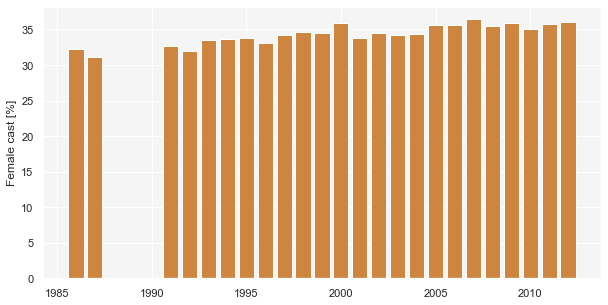

In [294]:
# Create figure
# Function to update lineplot when x or y range is changed

def genres_ts(genre_plot1, genre_plot2, genre_plot3, countries_plot1):
    f, ax = plt.subplots(figsize=(10, 5))
    plt.bar(time_series_genre['year'], time_series_genre['female_ratio']*100, color = 'peru',label = 'Average female cast [%]')
    ax.set_ylabel('Female cast [%]')
    
    if genre_plot1 != '':
        plt.plot(time_series_genre['year'],time_series_genre[genre_plot1]*100, linestyle = '--',  marker=".", label=genre_plot1, color = 'teal')

    if genre_plot2 != '':
        plt.plot(time_series_f_genre['year'],time_series_f_genre[genre_plot2]*100, linestyle = '--',  marker=".",label=genre_plot2, color = 'b')
    
    if genre_plot3 != '':
        plt.plot(time_series_m_genre['year'],time_series_m_genre[genre_plot3]*100,linestyle = '--',  marker=".", label=genre_plot3, color = 'indigo')
    
    if countries_plot1 != '':
        plt.plot(time_series_countries['year'],time_series_countries[countries_plot1]*100,linestyle = '--',  marker=".", label=countries_plot1, color = 'g')        
    '''
    if countries_plot_2 != '':
        plt.plot(time_series_countries['release_year'],time_series_countries[countries_plot_2]*100,linestyle = '--',  marker=".", label=countries_plot_2, color = 'violet')
    '''    
    ax.grid(visible=True, color='silver',axis='y')
    f.patch.set_facecolor('white')
    ax.set_facecolor('whitesmoke')
    ax.spines['bottom'].set_color('0.5')
    ax.spines['top'].set_color('0.5')
    ax.spines['right'].set_color('0.5')
    ax.spines['left'].set_color('0.5')
    
    g.set_title('Female Cast Ratio')
    g.tick_params(axis='x', rotation=45)
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
              ncol=3, fancybox=True, shadow=True)
    
    for ind, label in enumerate(g.get_xticklabels()):
        if ind % 5 == 0:  # every 10th label is kept 
            label.set_visible(True)
        else:
            label.set_visible(False)
            

# Create dropdown widgets for choosing x and y ranges
genre_plot1 = widgets.Dropdown(options= genre_list, value=genre_list[1], description='Top 20 genre:')
genre_plot2 = widgets.Dropdown(options=f_genre_list, value=f_genre_list[0], description='Female genre:')
genre_plot3 = widgets.Dropdown(options=m_genre_list, value=m_genre_list[0], description='Male genre:')
countries_plot1 = widgets.Dropdown(options=countries_list, value=countries_list[0], description='Country:')
#countries_plot_2 = widgets.Dropdown(options=countries_list, value=countries_list[0], description='Country:')


# Use interactive function to tie the lineplot update function to the dropdown widgets
widgets.interactive(genres_ts, genre_plot1=genre_plot1, genre_plot2=genre_plot2, genre_plot3=genre_plot3, countries_plot1 = countries_plot1)


In [295]:
movie_genres[movie_genres.genres == 'Erotica'].release_year.min()

1959

In [296]:
np.any(movies.movie_name == 'Deep Throat')

True

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
    We can see that the female cast ratio of the most popular genres overall increase and all but Thriller are higher than the average female cast ratio.

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
As we can see there is no clear pattern. It would be clearer to show the change of female ratio over time per year, not divided into genres. An analysis regarding genres could be clearer if just the 30 top female genres over a few different time period is shown.

## 3. Sentiment Analysis
[Back to table of contents](#ToC)

We extract the adjectives and verbs of each plot

### 3.1 Extract verbs and adjectives of the plot's summaries

In [297]:
# Load spacy pipeline
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities") # Merge entities like ['David' 'Bowie'] to ['David Bowie']

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [298]:
def tag_adj(text):
    """
    Find all noon/adjective pair in the given text
    :param text: Text composed of one or multiple sentences
    :return: list of noon/adjective pair
    """
    doc = nlp(text)
    noun_adj_pairs = []
    for token in doc:
        ## Is the word a proper noun / noun / pronoun
        if token.pos_ in ('PROPN', 'NOUN', 'PRON'):
            for child in token.children:
                ## Is the child an adjectival modifier
                if child.dep_ == 'amod':
                    noun_adj_pairs.append((token.lemma_, child.lemma_))
    return noun_adj_pairs

In [299]:
## Example
print(tag_adj("There is a red card in the blue envelope and a beautiful girl."))
print(tag_adj("She is beautiful."))

[('card', 'red'), ('envelope', 'blue'), ('girl', 'beautiful')]
[]


In [300]:
def tag_verb(text):
    """
    Find all noon/verb pair in the given text
    :param text: Text composed of one or multiple sentences
    :return: list of noon/verb pair
    """
    doc = nlp(text)
    verbs = []
    for possible_verb in doc:
        if possible_verb.pos_ == 'VERB':
            for possible_subject in possible_verb.children:
                if possible_subject.dep_ == 'nsubj':
                    verbs.append((possible_subject.lemma_, possible_verb.lemma_))
                    break
    return verbs

We extract the adjectives and verbs of each plot

In [ ]:
plots['verb'] = plots['plot'].apply(tag_verb) # long computation
plots['adj'] = plots['plot'].apply(tag_adj) # long computation

# Save intermediate result since computation is quite long
plots[['wiki_movie_id', 'verb', 'adj']].to_pickle('data/plots.pickle')

In [301]:
# Load saved result
plots[['wiki_movie_id', 'verb','adj']] = pd.read_pickle('data/plots.pickle')
plots.head()

,wiki_movie_id,plot,verb,adj
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[(Shlykov, develop)]","[(driver, work), (relationship, bizarre)]"
1,31186339,The nation of Panem consists of a wealthy Capi...,"[(nation, consist), (district, provide), (trib...","[(Capitol, wealthy), (district, poor), (rebell..."
2,20663735,Poovalli Induchoodan is sentenced for six yea...,"[(who, give), (who, achieve), (Induchoodan, lo...","[(son, only), (judge, idealist), (rank, top), ..."
3,2231378,"The Lemon Drop Kid , a New York City swindler,...","[(the Lemon Drop Kid, tout), (Kid, come), (Kid...","[(hustle, several), (hustle, successful), (wom..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...,"[(baby, sleep), (family, enjoy), (lindy, retur...","[(daughter, nine-week-old), (camper, fellow), ..."


In [302]:
# Dict that match all characters to their gender
matcher = pd.Series(characters.actor_gender.values, index=characters.character_name).to_dict()
matcher.update({'he' : 'M', 'she' : 'F'})

In [303]:
# We build a dataframe that groups the subject and the verb of every plot
gender_verb = pd.DataFrame(plots.verb.explode().to_list(), columns=['noon', 'verb'])
# We create a new column that assignee to subject to male or female based on the matcher
gender_verb['gender'] = gender_verb.noon.apply(matcher.get)
gender_verb.dropna(inplace=True)
gender_verb.head()

,noon,verb,gender
5,she,starve,F
6,he,warn,M
10,she,discover,F
12,he,say,M
20,she,recover,F


In [304]:
# We do the same for adjectives
gender_adj = pd.DataFrame(plots.adj.explode().to_list(), columns=['noon', 'adj'])
gender_adj['gender'] = gender_adj.noon.apply(matcher.get)
gender_adj.dropna(inplace=True)
gender_adj.head()

,noon,adj,gender
12,Haymitch Abernathy,past,M
19,Rue,die,F
53,woman,beautiful,F
56,Moran,furious,F
61,Santa Claus,cornerside,M


In [305]:
gender_adj.loc[gender_adj.gender == 'F'].adj.value_counts().head(10)

young         2256
beautiful      637
old            565
other          310
mysterious     180
elderly        159
pregnant       158
new            158
attractive     155
real           129
Name: adj, dtype: int64

In [306]:
gender_adj.loc[gender_adj.gender == 'M'].adj.value_counts().head(10)

young      469
real       258
local      195
new        181
old        170
former     163
little     127
corrupt    111
angry      103
first      100
Name: adj, dtype: int64

In [307]:
gender_verb.loc[gender_verb.gender == 'F'].verb.value_counts().head(10)

have     5166
tell     4209
go       4154
find     3873
leave    2887
get      2492
take     2473
try      2407
meet     2382
see      2373
Name: verb, dtype: int64

In [308]:
gender_verb.loc[gender_verb.gender == 'M'].verb.value_counts().head(10)

have     10558
go        8293
find      8261
tell      7102
take      6112
get       5853
try       5852
meet      5156
see       4865
leave     4705
Name: verb, dtype: int64

### 3.2  Sentiment Analysis and  Word Frequency 

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The types from tvtropes are not sufficient for sentiment analysis, since the dictionary is not large enough. Thus, we looked into current sentiment libraries to see if there is any finding. Here we tried nltk.

In [309]:
nltk_analyzer = SentimentIntensityAnalyzer()
gender_adj['nltk']=gender_adj['adj'].apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])
gender_adj.nltk.value_counts()

 0.0000    19122
 0.5994      660
 0.4404      345
-0.4019      309
-0.5106      300
           ...  
-0.6705        6
 0.1027        4
 0.6486        3
 0.0258        1
-0.6808        1
Name: nltk, Length: 71, dtype: int64

In [310]:
# compute positive and negative ratio 
def posneg_ratio(df):
    neg=df[df['nltk']<0].count()[0]
    pos=df[df['nltk']>0].count()[0]
    num= neg+ pos
    negrt=neg/num
    posrt=pos/num
    return (negrt, posrt)

In [311]:
male_neg_pos = posneg_ratio(gender_adj[gender_adj['gender']=='M'])
female_neg_pos = posneg_ratio(gender_adj[gender_adj['gender']=='F'])
print ('The negative and positive ratio for male is {:.2f}'.format(male_neg_pos[0]),'and {:.2f}'.format(male_neg_pos[1]))
print ('The negative and positive ratio for female is {:.2f}'.format(female_neg_pos[0]),'and {:.2f}'.format(female_neg_pos[1]))

The negative and positive ratio for male is 0.66 and 0.34
The negative and positive ratio for female is 0.48 and 0.52


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We see with the follow histogram of the non-neutral sentiment score of adjectives that there is difference in the adjectives used to describe males and females.


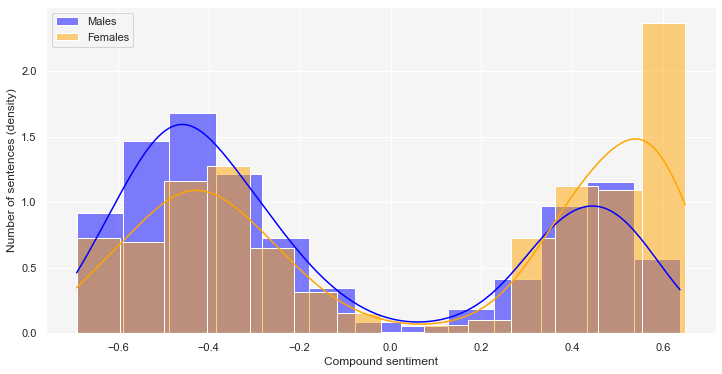

In [312]:
_, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(gender_adj[(gender_adj.gender == 'M') & (gender_adj.nltk != 0)].nltk, kde=True, stat='density', color='blue', label='Males')
ax = sns.histplot(gender_adj[(gender_adj.gender == 'F') & (gender_adj.nltk != 0)].nltk, kde=True, stat='density', color='orange', label='Females')
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences (density)')
plt.legend()

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We filtered out these neutral words and use the adjectives left that show polarity to compute the negative and postive ratio of description in movie plots for men and women. It turns out men are much more negatively described. But is it actually the case? we are not able to conclude for now, because the number of neutral words are much more than expected. Among 27177 adjectives, 19122 were labelled as neutral by NLTK. So we tried to see if we could get any insight from word frequency instead.

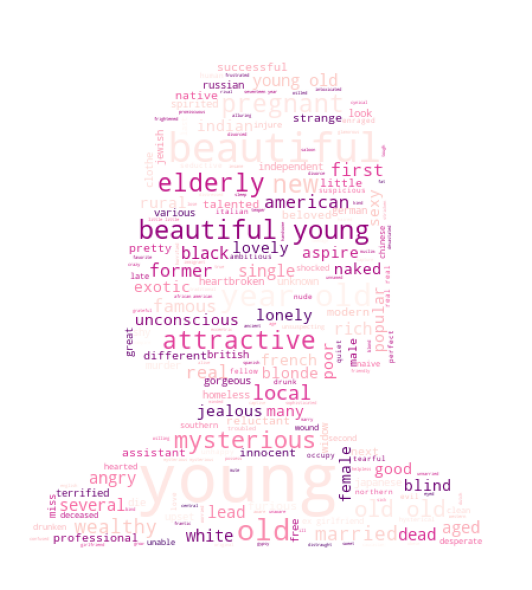

In [313]:
female = gender_adj[gender_adj['gender']=='F']
mask_fem = np.array(Image.open("fem_mask.png"))
wordcloud = WordCloud(background_color="White",colormap ='RdPu',mask = mask_fem,random_state=42).generate(' '.join(female['adj']))
image_colors = ImageColorGenerator(mask_fem)
plt.figure(facecolor='w',figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

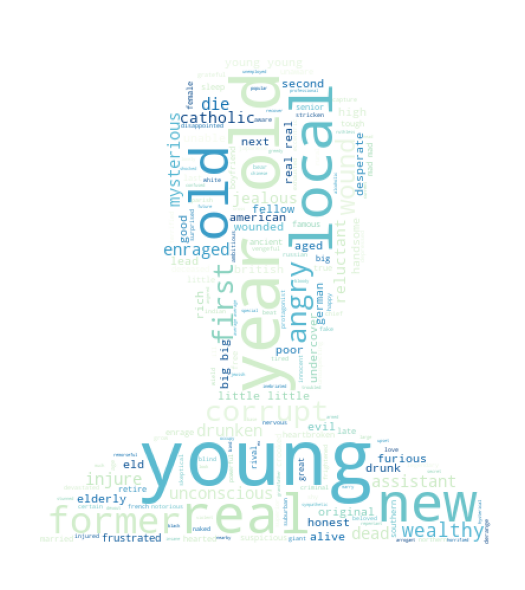

In [314]:
male = gender_adj[gender_adj['gender']=='M']
mask_mal = np.array(Image.open("mal_mask.png"))
wordcloud = WordCloud(background_color="white",mask = mask_mal,random_state=42,colormap='GnBu').generate(' '.join(male['adj']))
plt.figure(facecolor='w',figsize=(14,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Sentiment analysis on verbs

In [315]:
nltk_analyzer = SentimentIntensityAnalyzer()
gender_verb['score'] = gender_verb.verb.apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])

In [316]:
gender_verb.head()

,noon,verb,gender,score
5,she,starve,F,-0.4404
6,he,warn,M,-0.1027
10,she,discover,F,0.0000
12,he,say,M,0.0000
20,she,recover,F,0.0000


<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Positive verbs

In [317]:
gender_verb.loc[(gender_verb.gender == 'F') & (gender_verb.score > 0.05)].verb.value_counts().head(10)

want      2183
love      1249
agree     1072
accept     737
escape     711
help       510
admit      432
like       422
invite     414
join       404
Name: verb, dtype: int64

In [318]:
gender_verb.loc[(gender_verb.gender == 'M') & (gender_verb.score > 0.05)].verb.value_counts().head(10)

want        3944
escape      1990
agree       1981
love        1540
help        1137
play        1045
accept       931
save         915
win          902
convince     825
Name: verb, dtype: int64

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
Negative verbs

In [319]:
gender_verb.loc[(gender_verb.gender == 'F') & (gender_verb.score < -0.05)].verb.value_counts().head(10)

leave       2887
refuse      1365
die         1191
kill         776
lose         630
confront     426
hide         371
shoot        365
stop         340
reject       326
Name: verb, dtype: int64

In [320]:
gender_verb.loc[(gender_verb.gender == 'M') & (gender_verb.score < -0.05)].verb.value_counts().head(10)

leave       4705
kill        3154
refuse      2271
die         2056
lose        1626
shoot       1226
stop         935
steal        876
confront     873
hide         798
Name: verb, dtype: int64

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We see with the follow histogram of the non-neutral sentiment score of verbs that there is no significant difference in verbs usage between males and females.


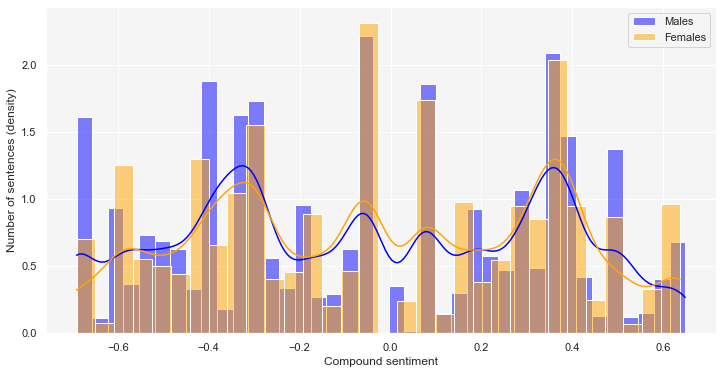

In [321]:
_, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(gender_verb[(gender_verb.gender == 'M') & (gender_verb.score != 0)].score, kde=True, stat='density', color='blue', label='Males')
ax = sns.histplot(gender_verb[(gender_verb.gender == 'F') & (gender_verb.score != 0)].score, kde=True, stat='density', color='orange', label='Females')
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences (density)')
plt.legend()

### 3.3 Extract sentences for both genders

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We extract the sentences talking about a character, and we classified them with the gender of the character that appear.

In [ ]:
male_sent = set()
female_sent = set()
matcher = pd.Series(characters.actor_gender.values, index=characters.character_name).to_dict()

def extract_sent(text: str):
    doc = nlp(text)
    for word in doc:
        if matcher.get(word.text) == 'F':
            female_sent.add(word.sent.text)
        elif matcher.get(word.text) == 'M':
            male_sent.add(word.sent.text)

In [ ]:
plots['plot'].apply(extract_sent) # long computation

In [ ]:
male_sentences = pd.DataFrame({'sent': list(male_sent)})
female_sentences = pd.DataFrame({'sent': list(female_sent)})

### 3.4 Sentiment Analysis on sentences

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We give a sentiment score to each sentences to see if a gender is conoted more positivly or negativly.

In [ ]:
nltk_analyzer = SentimentIntensityAnalyzer()
male_sentences['score'] = male_sentences.sent.apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])
female_sentences['score'] = female_sentences.sent.apply(lambda x: nltk_analyzer.polarity_scores(x)['compound'])

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
The distribution of the score is the same for males and females sentences. So there is no gender which is conoted more positivly or negativly in the summary.

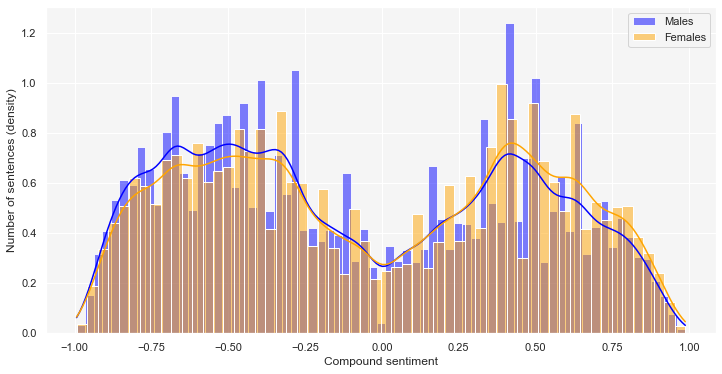

In [327]:
_, ax = plt.subplots(figsize=(12, 6))
ax = sns.histplot(male_sentences.score[male_sentences.score != 0], kde=True, stat='density', color='blue', label='Males')
ax = sns.histplot(female_sentences.score[female_sentences.score != 0], kde=True, stat='density', color='orange', label='Females')
plt.xlabel('Compound sentiment')
plt.ylabel('Number of sentences (density)')
plt.legend()

### 3.5 Topic modelling on sentences

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We try to find the topics of the sentences for both genders to see if there is any inequality.

In [323]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
def process_sent(sent: str):
    doc = nlp(sent)
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]
    return doc

In [ ]:
male_sentences['processed'] = male_sentences.sent.apply(process_sent) # long computation
female_sentences['processed'] = female_sentences.sent.apply(process_sent)

# Save result
male_sentences.to_pickle('data/male_sentences.pickle')
female_sentences.to_pickle('data/female_sentences.pickle')

In [324]:
# Load result
male_sentences = pd.read_pickle('data/male_sentences.pickle')
female_sentences = pd.read_pickle('data/female_sentences.pickle')

In [325]:
male_sentences.head()

,sent,score,processed
0,The search for the transmitter reveals the pre...,0.1027,"[search, transmitter, reveal, presence, surviv..."
1,"After interrogating the three Abarangers, the ...",0.0000,"[interrogate, abaranger, dekaranger, order, br..."
2,Finding a BB gun Hogarth left near the substat...,-0.3400,"[find, gun, Hogarth, leave, near, substation, ..."
3,"The film revolves around crisis negotiator, Li...",-0.6249,"[film, revolve, crisis, negotiator, Lieutenant]"
4,Señorella and Don Jose are married.,0.0000,"[Señorella, married]"


In [326]:
female_sentences.head()

,sent,score,processed
0,Gayle is now a guide dog trainer for the visua...,0.0000,"[gayle, guide, dog, trainer, visually, handica..."
1,"In fury, Asher begins beating and choking her ...",-0.9118,"[fury, Asher, begin, beat, choke, eventually, ..."
2,"Meanwhile, Cheryl takes Andy's dog to a psychi...",-0.7269,"[Cheryl, Andy, dog, psychiatrist, tell, promis..."
3,While Mary and Nini are shocked at the situati...,0.1531,"[Mary, Nini, shock, situation, Kelly, walk, Ch..."
4,After she learns that Quincy is engaged and me...,0.6994,"[learn, Quincy, engage, meet, fiancée, Kyra, M..."


In [332]:
dictionary = Dictionary(male_sentences['processed'])
dictionary.filter_extremes()
corpus = [dictionary.doc2bow(doc) for doc in male_sentences['processed']]
model_males = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=8, passes=10)

In [333]:
dictionary = Dictionary(female_sentences['processed'])
dictionary.filter_extremes()
corpus = [dictionary.doc2bow(doc) for doc in female_sentences['processed']]
model_females = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=8, passes=10)

In [334]:
model_males.show_topics()

[(0,
  '0.033*"film" + 0.019*"story" + 0.012*"end" + 0.010*"movie" + 0.009*"life" + 0.009*"play" + 0.009*"begin" + 0.006*"scene" + 0.006*"star" + 0.006*"character"'),
 (1,
  '0.023*"Tom" + 0.013*"Jerry" + 0.011*"Sam" + 0.007*"head" + 0.007*"kiss" + 0.006*"hand" + 0.006*"turn" + 0.006*"King" + 0.005*"face" + 0.005*"cat"'),
 (2,
  '0.008*"help" + 0.008*"try" + 0.007*"Jack" + 0.007*"life" + 0.007*"find" + 0.006*"relationship" + 0.006*"begin" + 0.006*"offer" + 0.005*"tell" + 0.005*"need"'),
 (3,
  '0.022*"run" + 0.021*"away" + 0.016*"car" + 0.015*"find" + 0.012*"house" + 0.010*"drive" + 0.010*"leave" + 0.009*"walk" + 0.007*"door" + 0.006*"home"'),
 (4,
  '0.013*"police" + 0.009*"gang" + 0.009*"officer" + 0.008*"team" + 0.007*"lead" + 0.007*"plan" + 0.007*"agent" + 0.006*"member" + 0.006*"case" + 0.006*"order"'),
 (5,
  '0.021*"kill" + 0.019*"escape" + 0.015*"shoot" + 0.014*"attack" + 0.009*"manage" + 0.009*"gun" + 0.009*"fight" + 0.008*"fire" + 0.007*"destroy" + 0.007*"save"'),
 (6,
  '0.0

In [335]:
model_females.show_topics()

[(0,
  '0.017*"life" + 0.012*"live" + 0.010*"Earth" + 0.008*"woman" + 0.007*"young" + 0.006*"child" + 0.006*"world" + 0.006*"family" + 0.006*"story" + 0.005*"city"'),
 (1,
  '0.013*"kill" + 0.012*"find" + 0.011*"escape" + 0.010*"shoot" + 0.009*"run" + 0.007*"try" + 0.007*"attack" + 0.007*"house" + 0.007*"manage" + 0.006*"body"'),
 (2,
  '0.022*"daughter" + 0.015*"son" + 0.014*"wife" + 0.011*"family" + 0.009*"young" + 0.009*"live" + 0.009*"mother" + 0.008*"meet" + 0.008*"father" + 0.008*"Jane"'),
 (3,
  '0.025*"tell" + 0.019*"father" + 0.018*"marry" + 0.014*"want" + 0.012*"mother" + 0.011*"family" + 0.010*"leave" + 0.009*"marriage" + 0.009*"know" + 0.008*"feel"'),
 (4,
  '0.014*"police" + 0.010*"find" + 0.009*"steal" + 0.009*"try" + 0.008*"money" + 0.007*"car" + 0.006*"leave" + 0.006*"ship" + 0.006*"train" + 0.006*"station"'),
 (5,
  '0.072*"love" + 0.041*"fall" + 0.014*"drive" + 0.010*"meet" + 0.010*"car" + 0.008*"away" + 0.007*"leave" + 0.006*"realize" + 0.006*"accident" + 0.006*"Pete

<div class="1.1" style='background-color:#c8dfea; padding:1em;'>
<span style="color:black">
We plot the difference martix between the topics.

<span style="color:red"> *Red cell* </span> - strongly decorrelated topics

<span style="color:blue"> *Blue cell* </span> - strongly correlated topics

In [336]:
def plot_diff(mdiff):
    fig, ax = plt.subplots(figsize=(10, 8))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
    plt.colorbar(data)
    data.set_clim(0, 1)

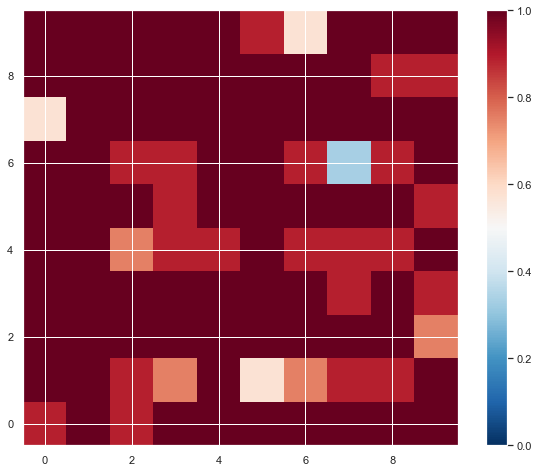

In [345]:
mdiff, _ = model_females.diff(model_males, distance='jaccard', num_words=5)
plot_diff(mdiff)

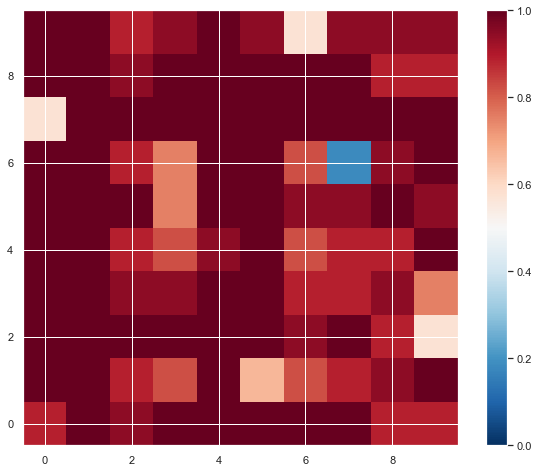

In [346]:
mdiff, _ = model_females.diff(model_males, distance='jaccard', num_words=10)
plot_diff(mdiff)

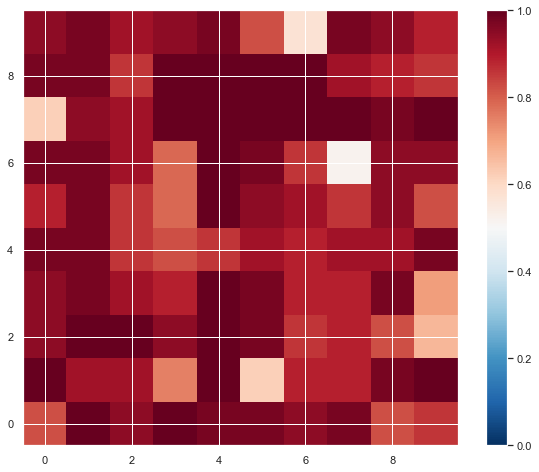

In [347]:
mdiff, _ = model_females.diff(model_males, distance='jaccard', num_words=20)
plot_diff(mdiff)

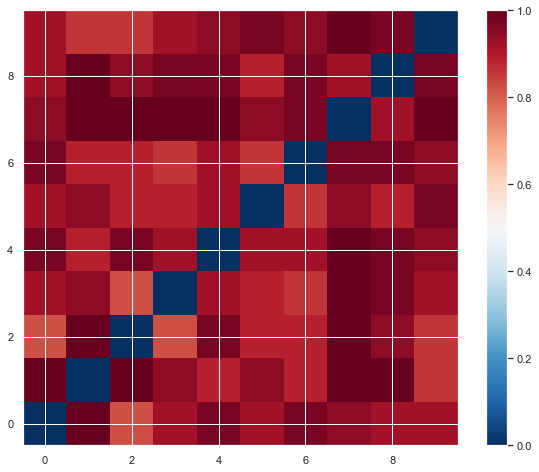

In [343]:
mdiff, _ = model_females.diff(model_females, distance='jaccard', num_words=20)
plot_diff(mdiff)

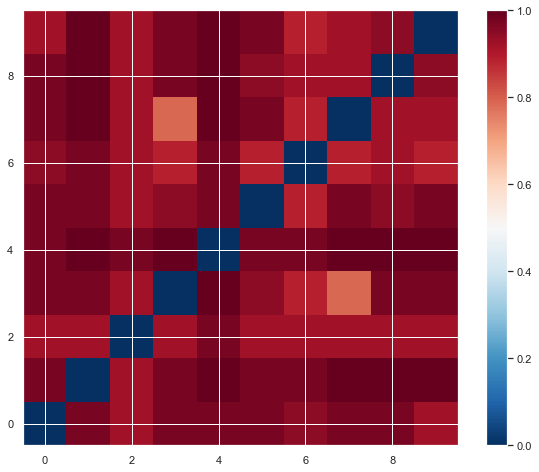

In [344]:
mdiff, _ = model_males.diff(model_males, distance='jaccard', num_words=20)
plot_diff(mdiff)